# Example of using plotting functionalities and Centroid comparisons

In [1]:
import requests
import lightkurve as lk
from astropy import units as u

from exovetter.tce import Tce
from exovetter import const as exo_const
from exovetter import vetters as vet
from exovetter import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 125


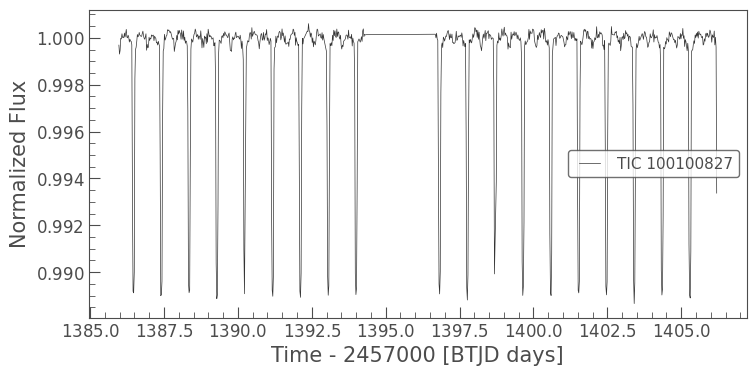

In [2]:
# Get the tce and lightkurve as done before
r = requests.get(url = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/WASP-18 b/properties/") 
nexsci_prop = r.json() [1]  

tce = Tce(period = nexsci_prop['orbital_period'] * u.day,
         epoch = nexsci_prop['transit_time'] * u.day,
         epoch_offset =  -2_400_000.5 * u.day,
         depth = nexsci_prop['transit_depth'] * exo_const.frac_amp,
         duration = nexsci_prop['transit_duration'] * u.day,
         snr = 50, 
         event_name = "WASP-18 b",
         target_name = "WASP-18")

# Lightcurve
lcf = lk.search_lightcurve(target = 'TIC100100827', mission = "TESS", sector = 3)[1].download()
lcf.select_flux(flux_column="sap_flux")
lc = lcf.remove_nans().remove_outliers()
flat = lc.flatten(window_length=81)

flat.plot()
plt.show()

## Some helpful diagnostic plots

All the vetters come with a plot method. You can also specify the plot parameter to True when running the vetter itself to get the same result. We demonstrate some of the packages plotting capabilities by first displaying the folded light curve, then showing the default diagnostic plots from four vetters: modshift, SWEET, odd even, viz_transit.


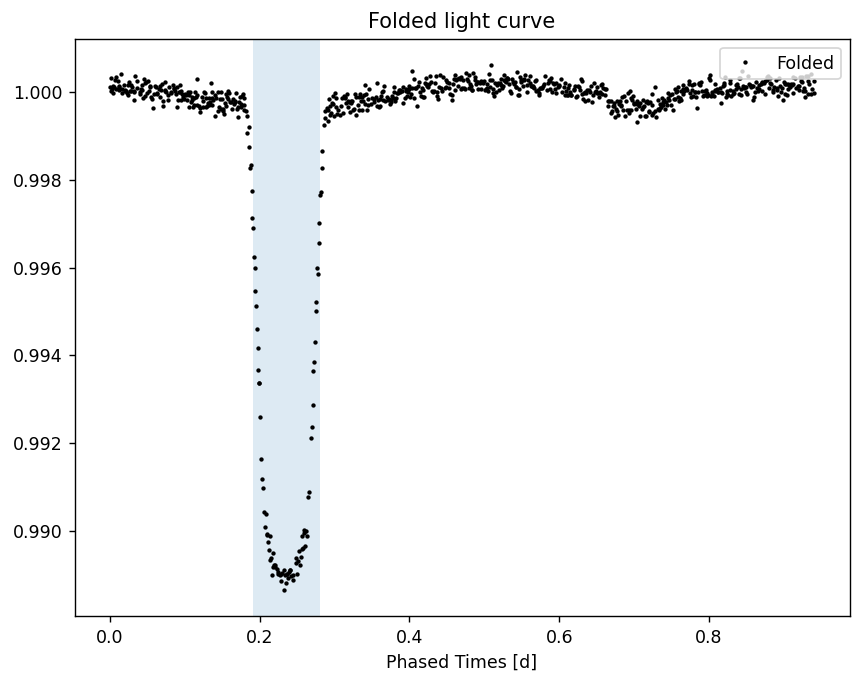

In [3]:
# The viz transit class has a ton of useful plotting options, shown more later. 
# Here we'll use it to simply display the folded lightcurve

viz = vet.VizTransits(smooth=None, folded_plot=True) 
viz_results = viz.run(tce, flat)
plt.title('Folded light curve')
plt.show()

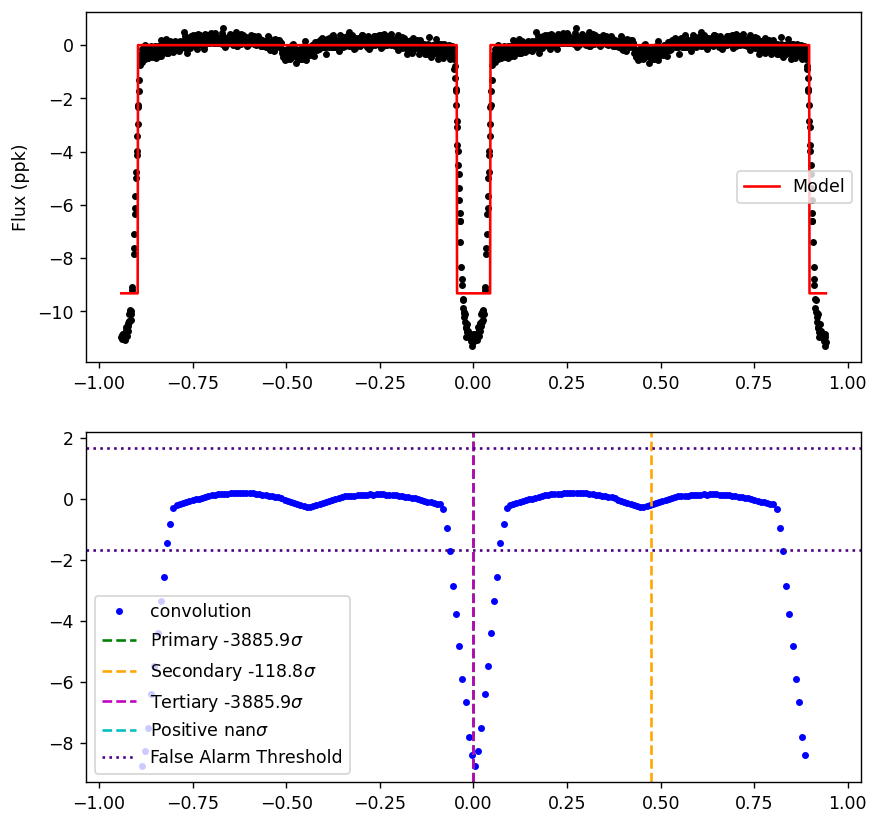

In [4]:
# Example of using the plot method after running the vetter
modshift = vet.ModShift()
modshift_results = modshift.run(tce, flat)

modshift.plot()


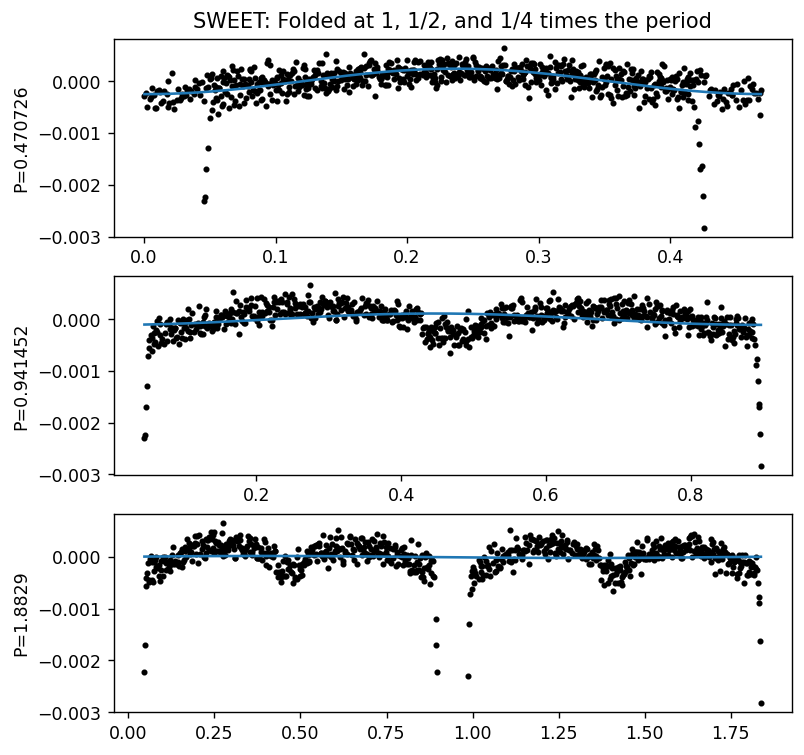

In [5]:
# Example of using the plot parameter while running the vetter
sweet = vet.Sweet()
sweet_results = sweet.run(tce, flat, plot=True)


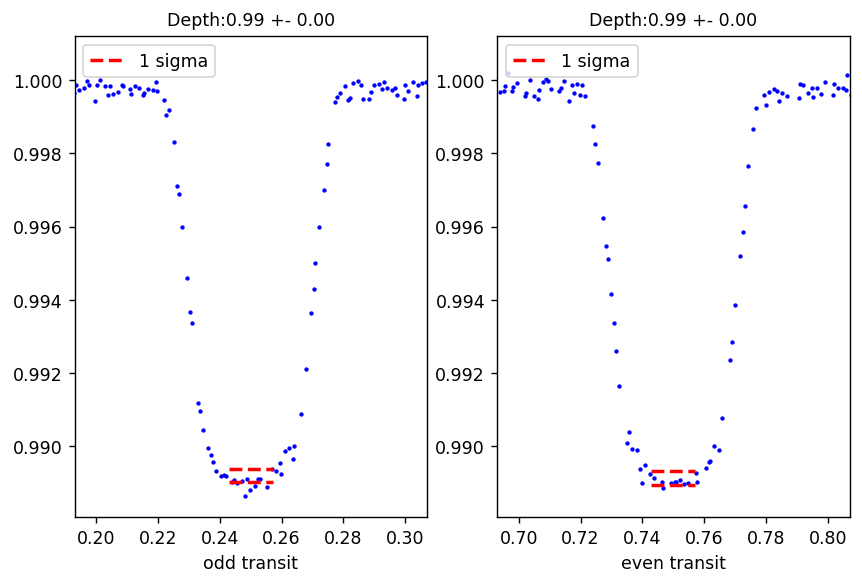

In [6]:
odd_even = vet.OddEven()
odd_even_results = odd_even.run(tce,flat)
odd_even.plot()


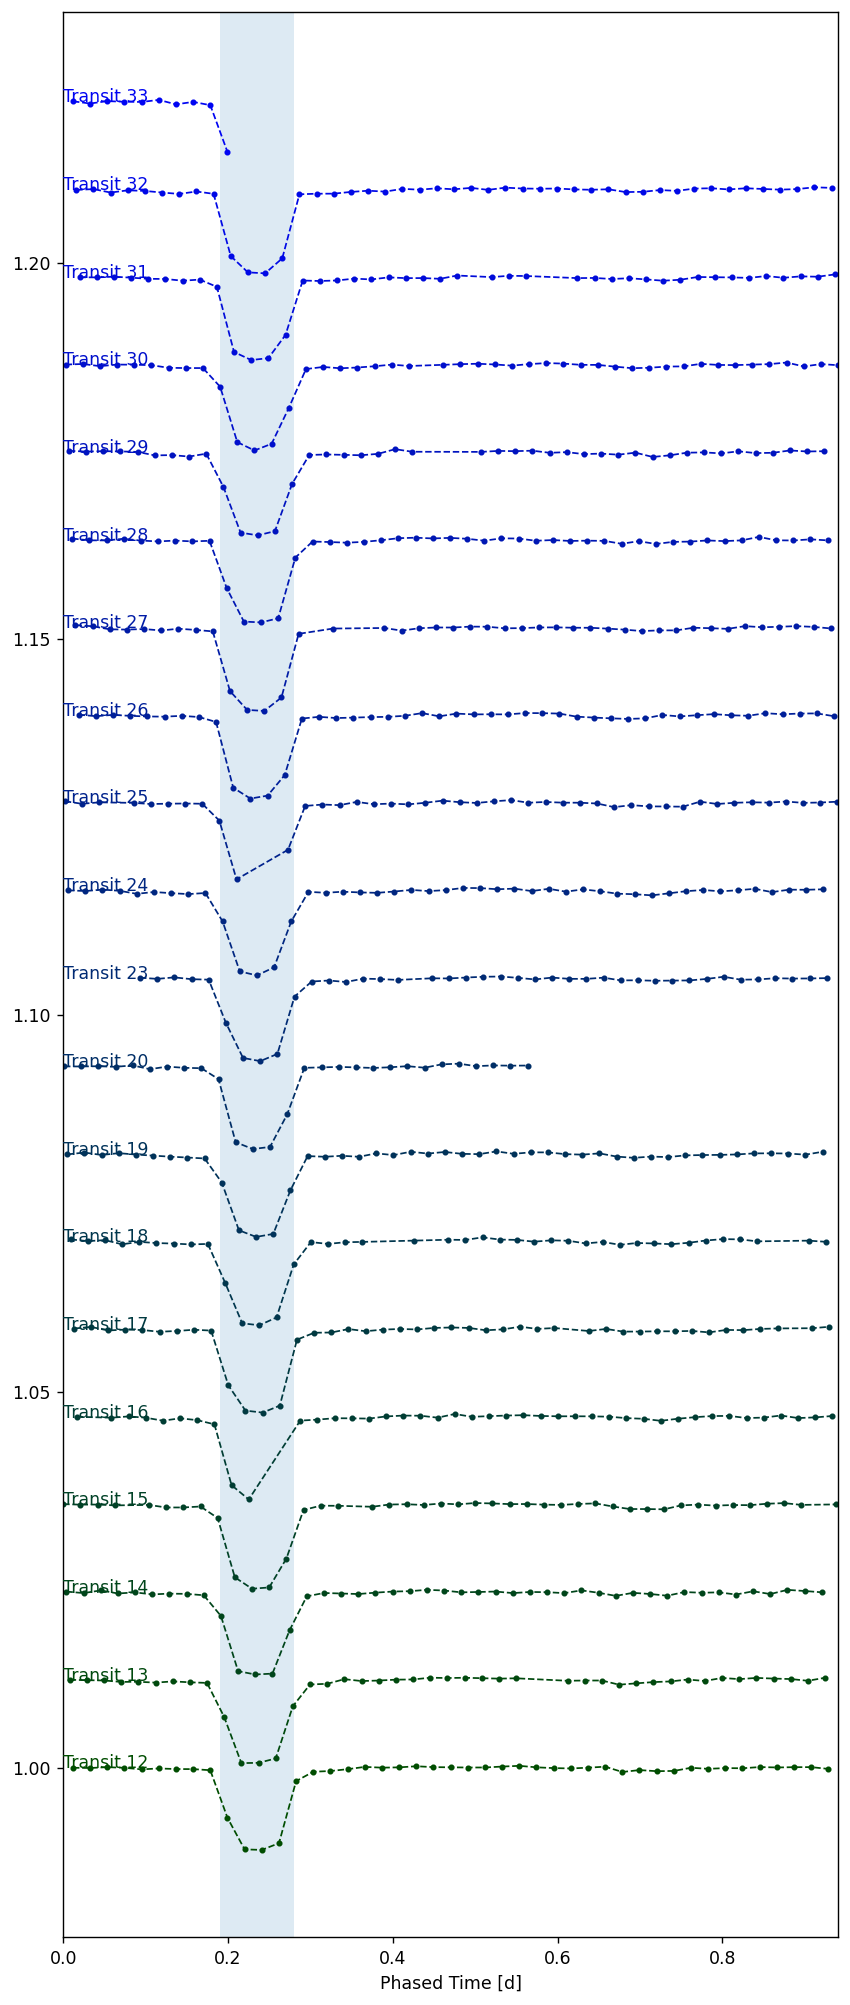

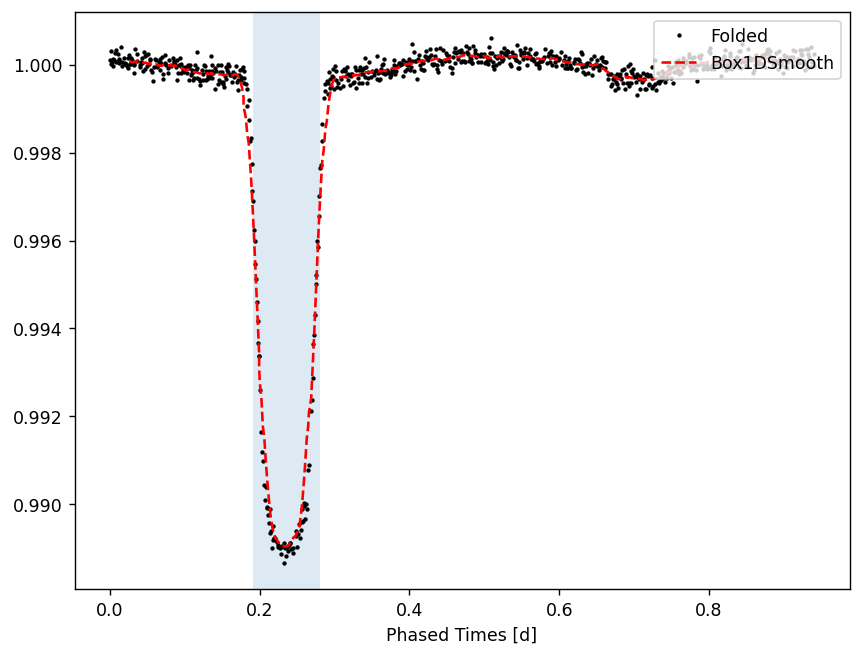

In [7]:
# As demonstrated at above with smooth, VizTransit has a lot of parameters, here just using default
viz = vet.VizTransits(max_transits=20) 
viz_results = viz.run(tce, flat)
viz.plot()

## Centroid Vetting

Centroid returns the average offset and significance that it is on the target.
You get several plots showing the out of transits, in transit and difference image. The centroids of each are measured using a Gaussian. For the OOT and In-Transit, the centroid is constrained to the central +/-1pixel in box row and column direction. As input, the Centroid Vetter requires a Target Pixel File objects from lightkurve.

This example shows no significant offset between the out of transit location and the difference image centroid.

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,TESS-SPOC,1800,100100827,0.0


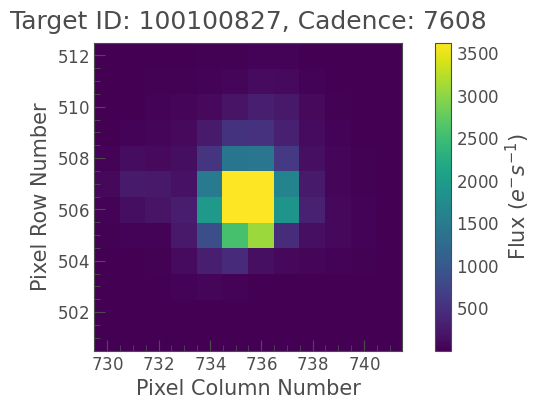

In [8]:
# Return a search result for the relevent target pixel file
search_result = lk.search_targetpixelfile(target = 'TIC100100827', sector=3, exptime=1800)

# Show what one of these results look like
display(search_result)

# Download the file to use
tpf = search_result.download()

# Show what it looks like
tpf.plot()
plt.show()

In [9]:
viz_results

{'num_transits': 20}

/user/mdallas/exovetter_project/exovetter_working_code/exovetter/exovetter/centroid/centroid.py:281: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


number of figs 21
number of centroids 21


{'offset': 0.3120732981252742, 'significance': array([0.13463567])}

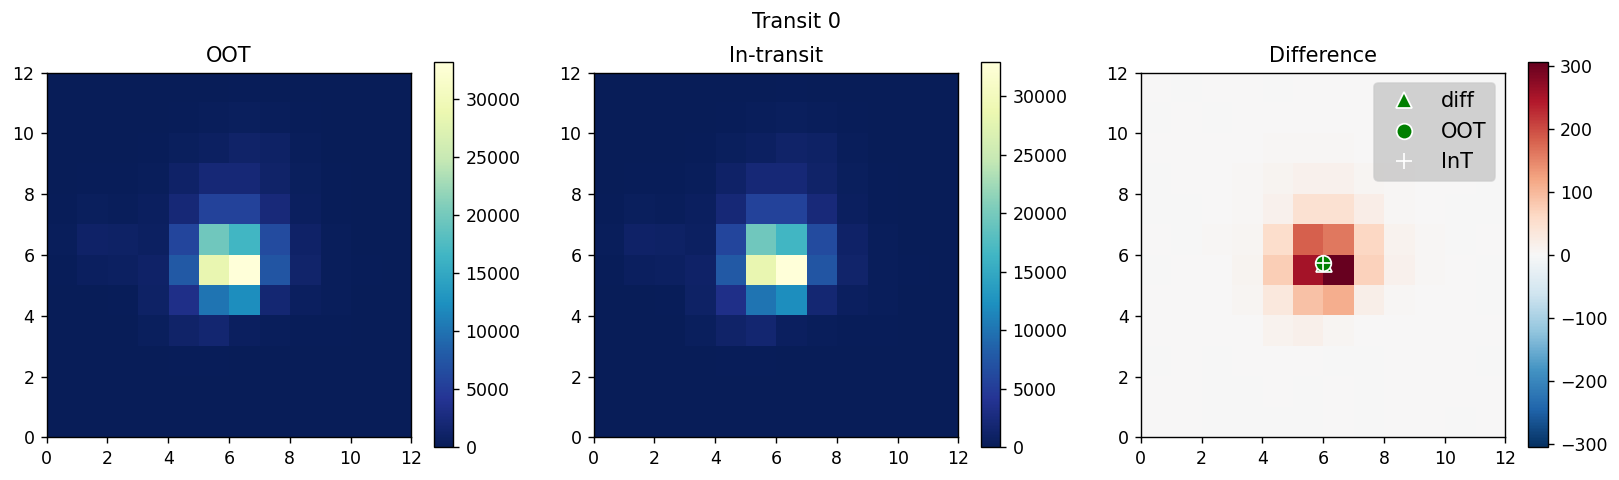

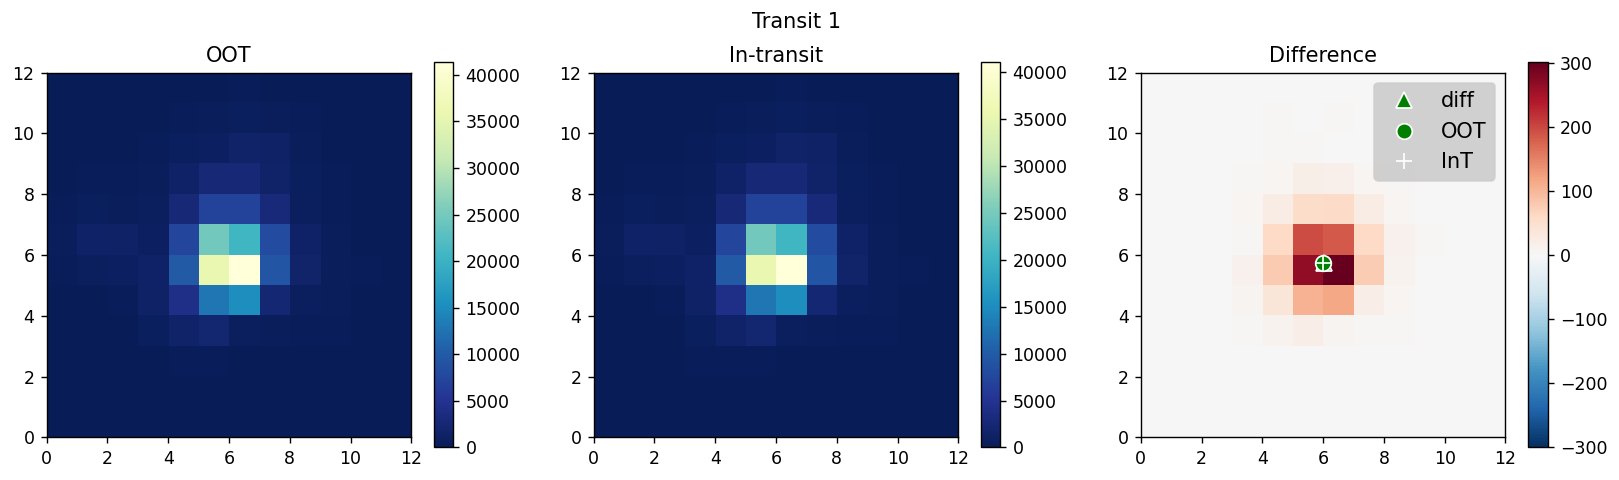

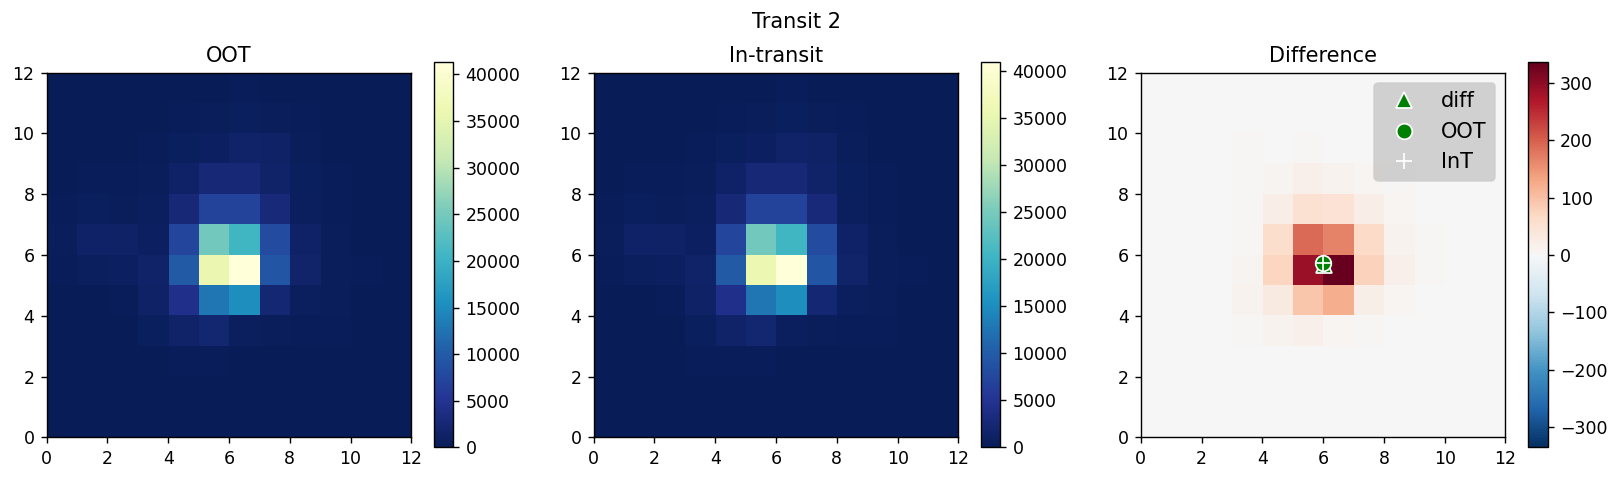

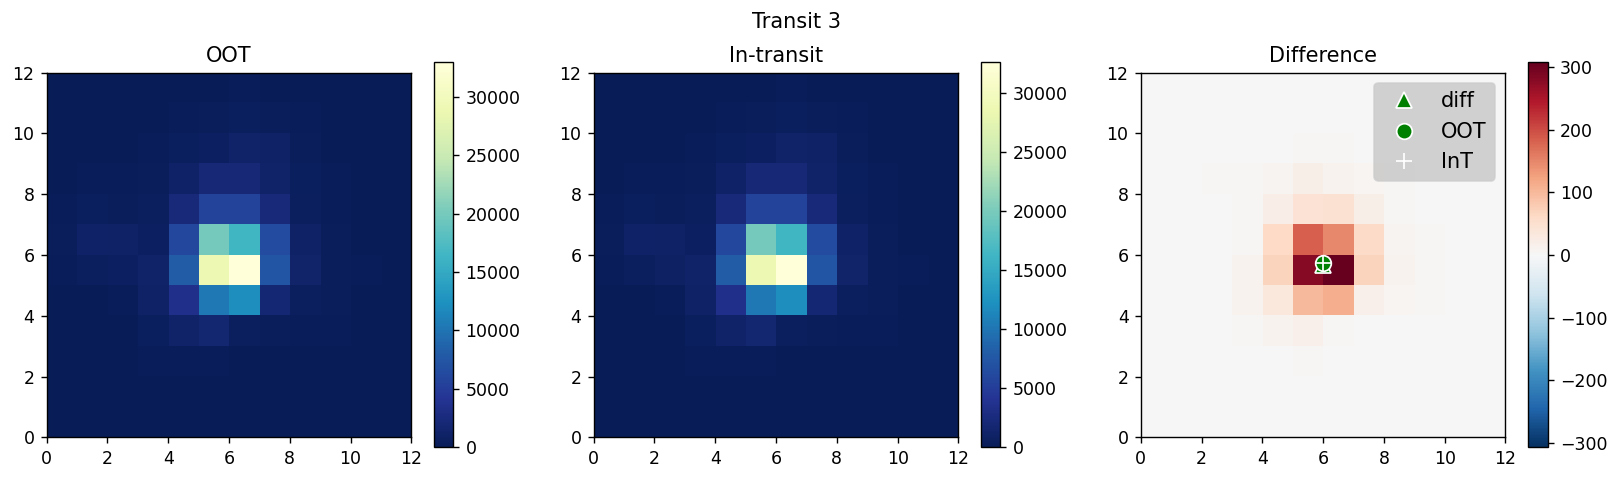

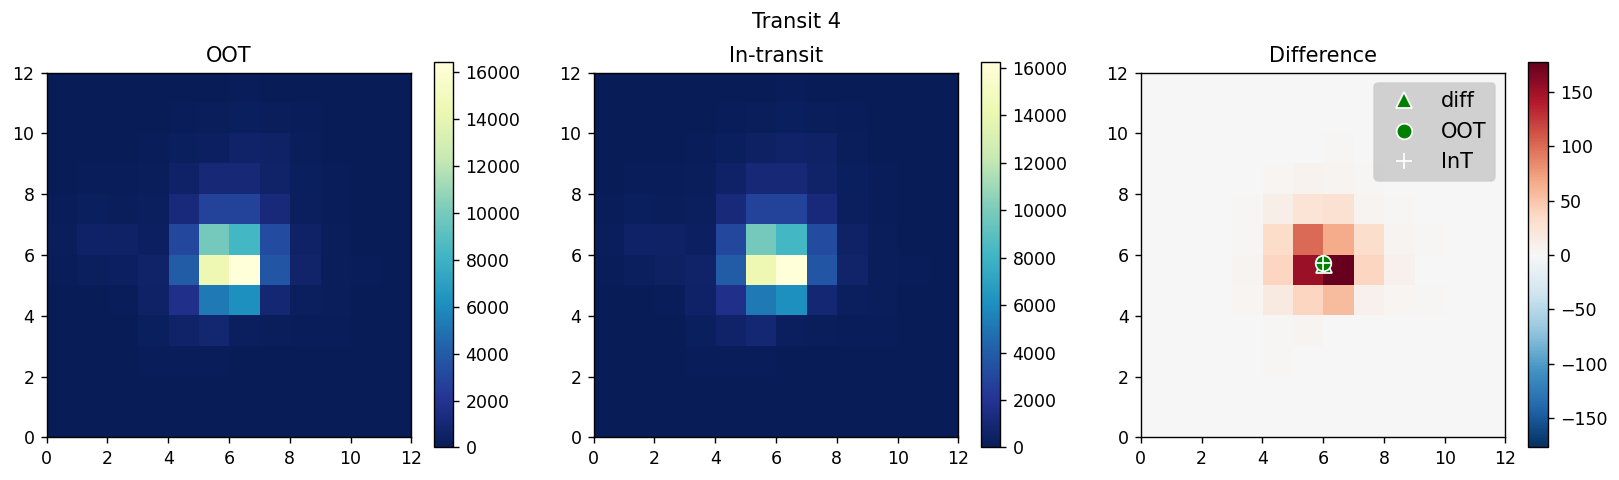

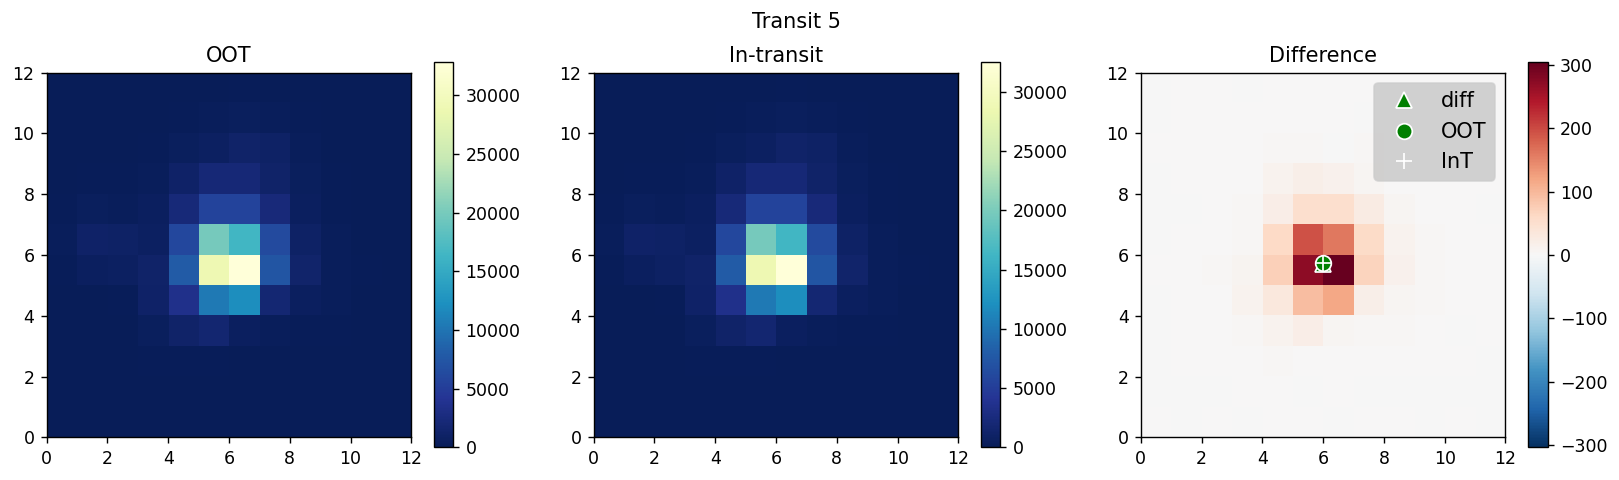

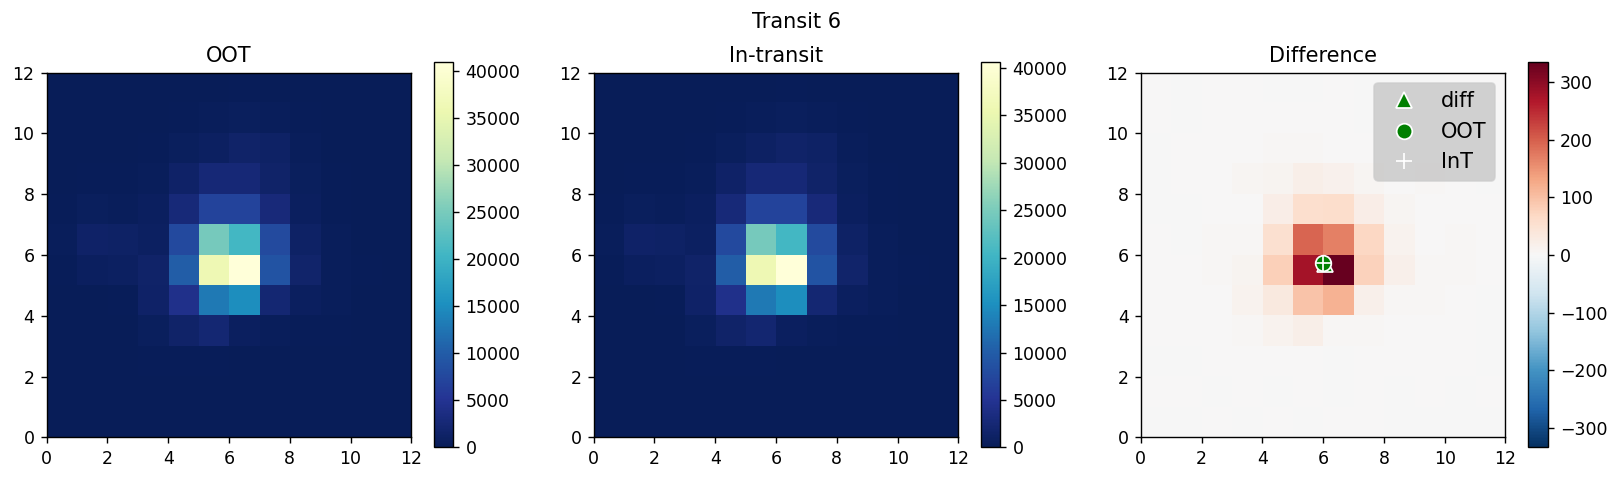

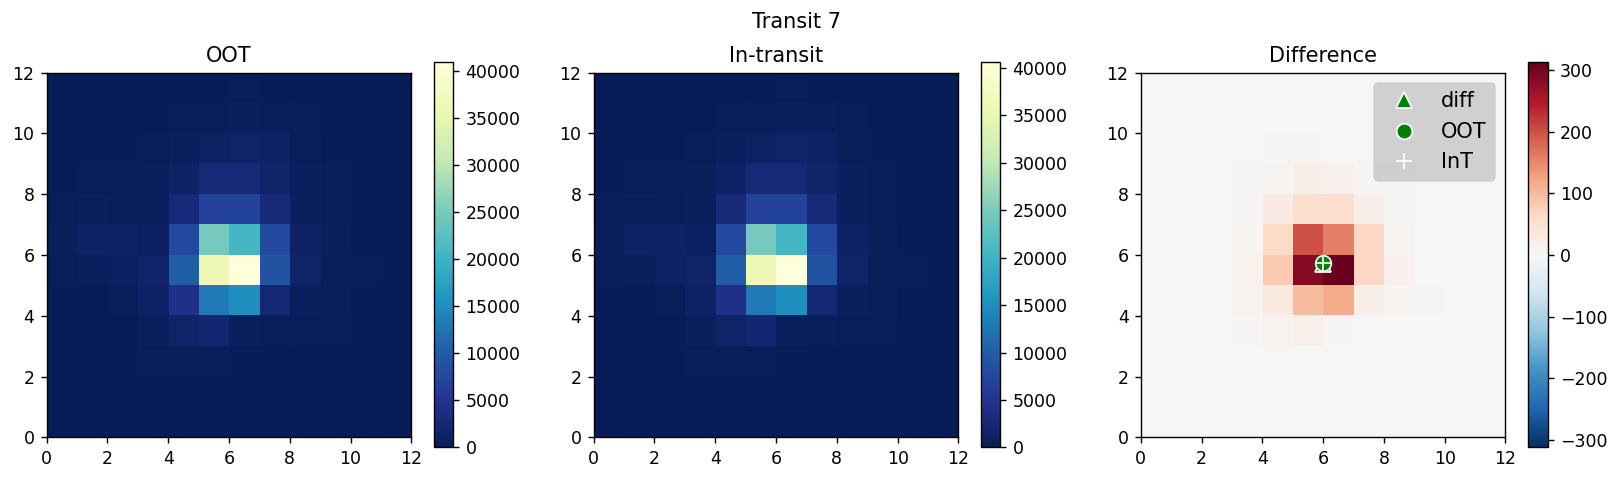

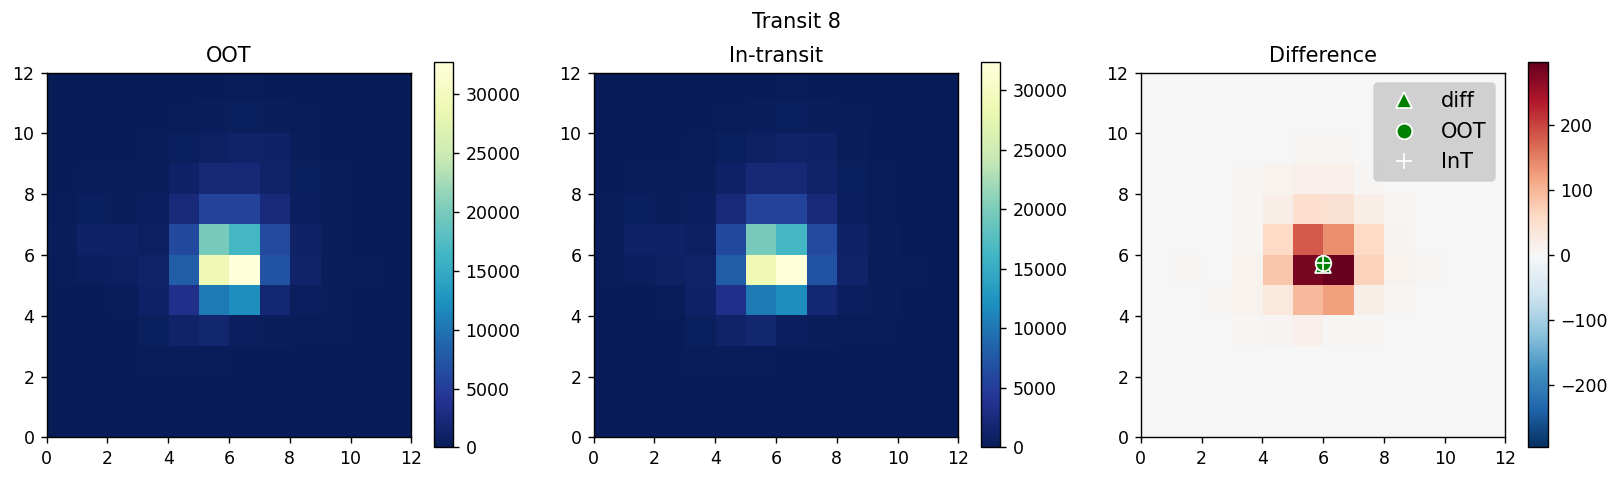

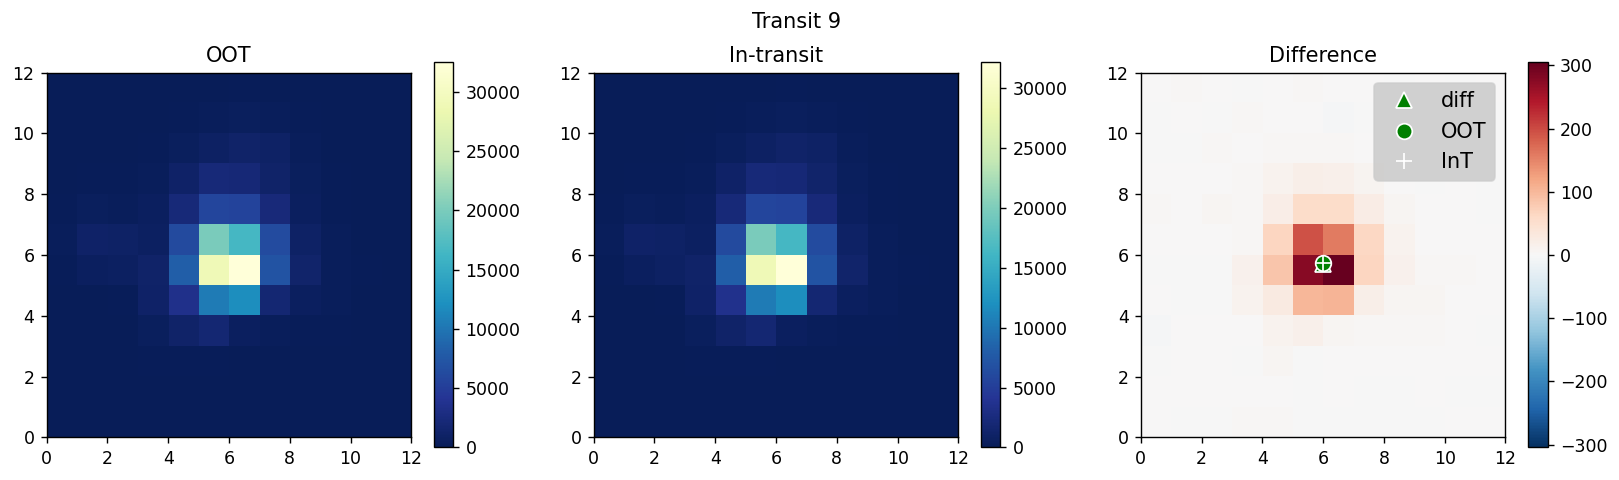

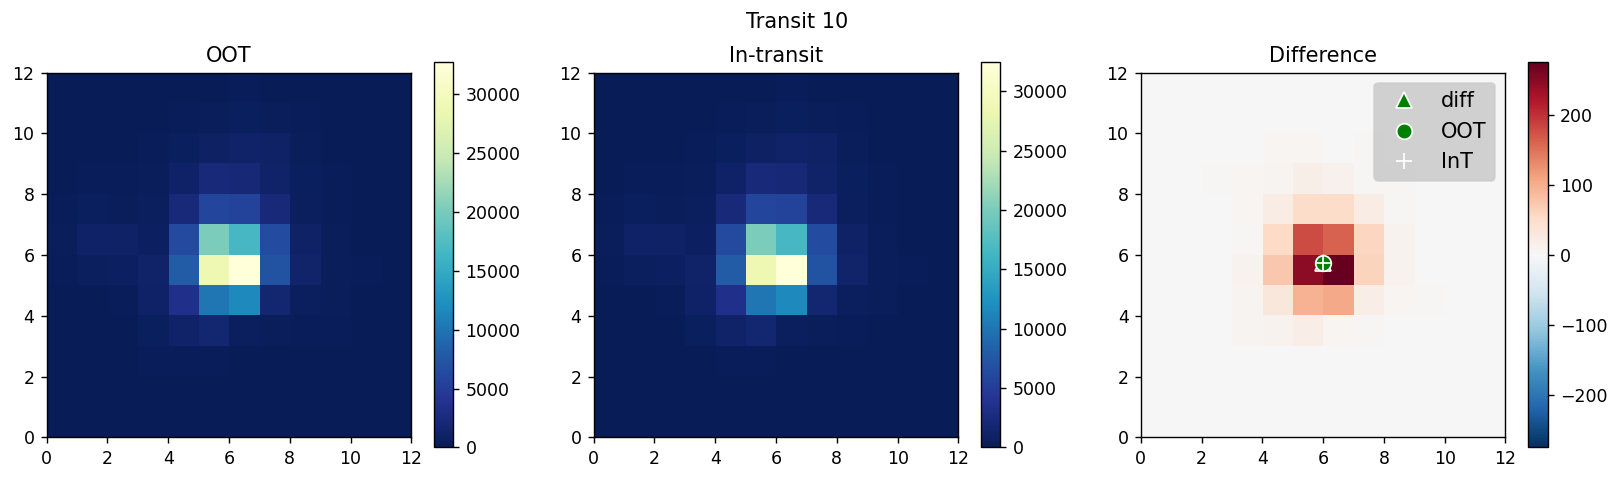

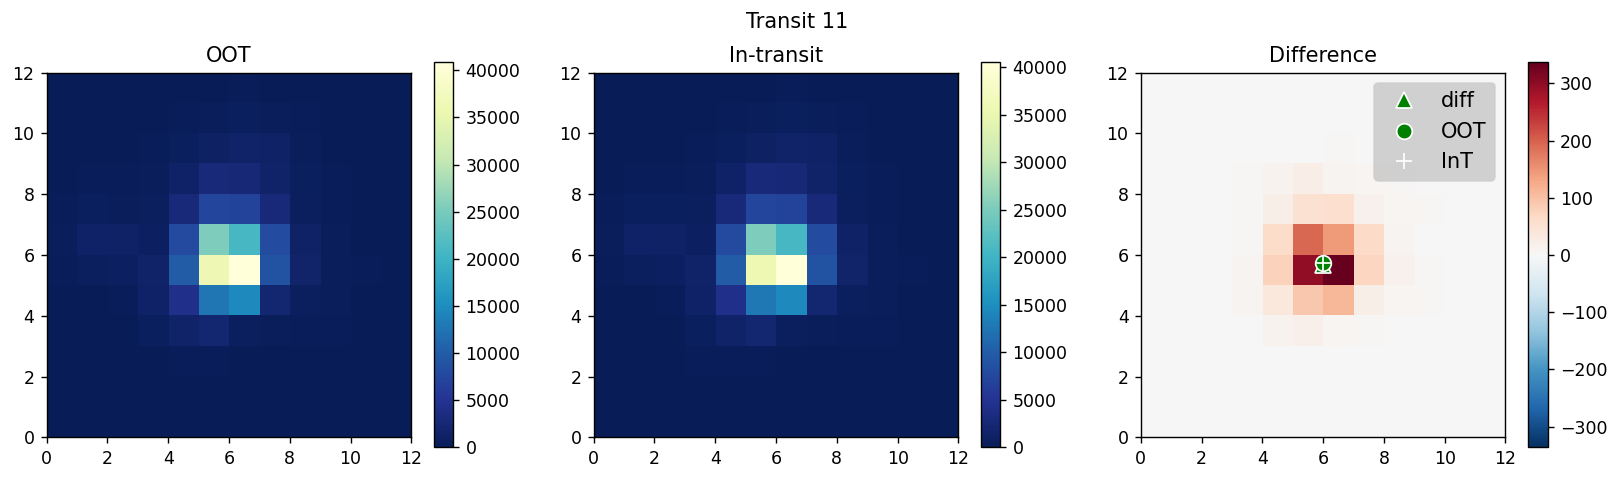

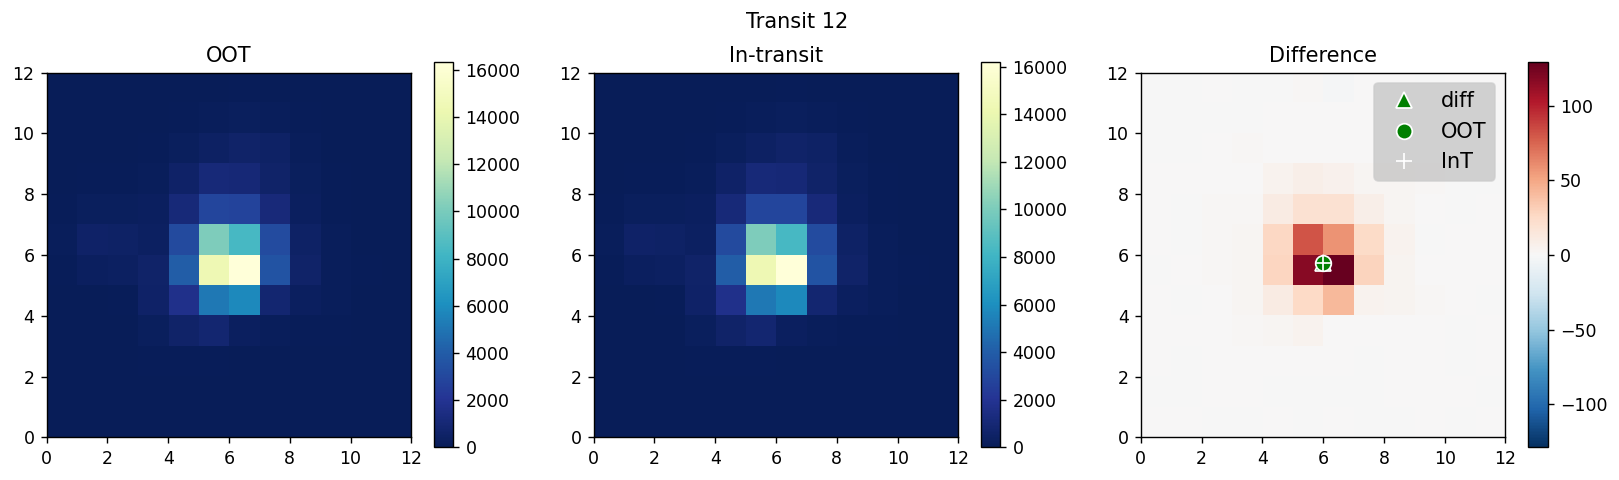

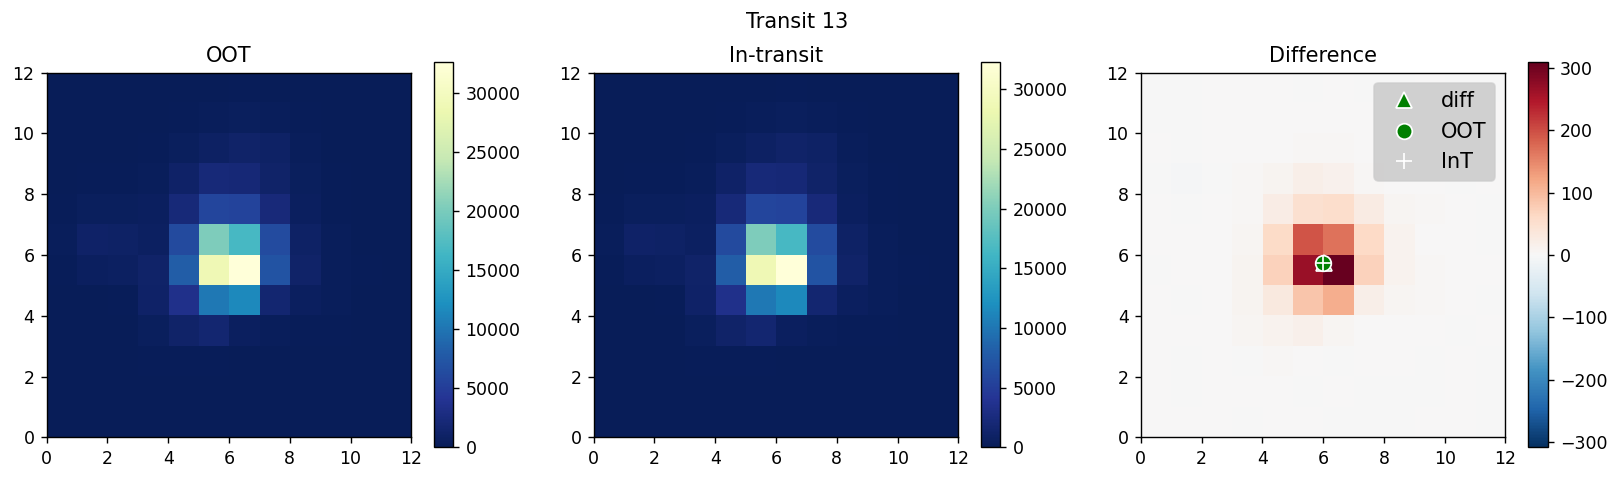

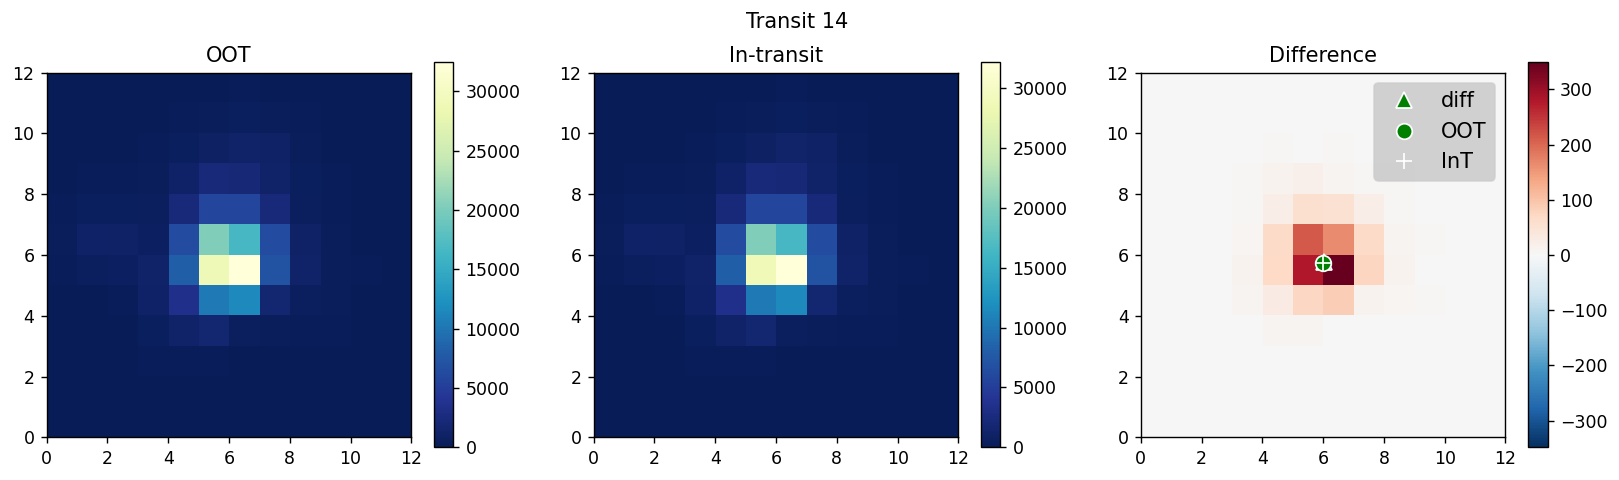

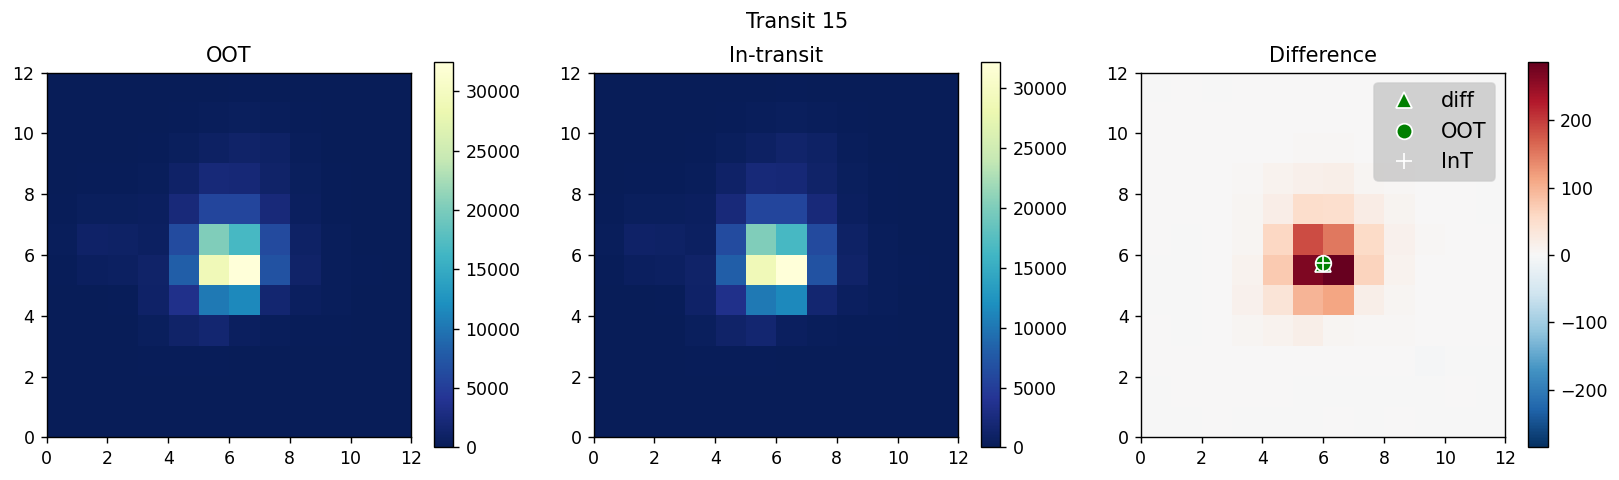

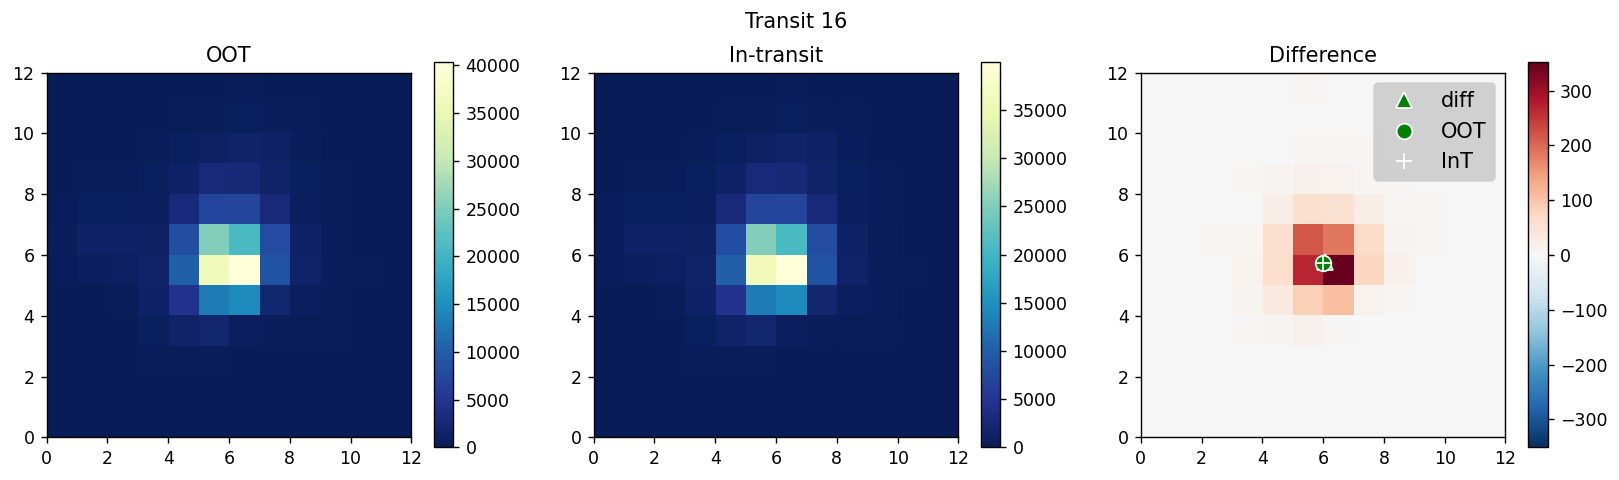

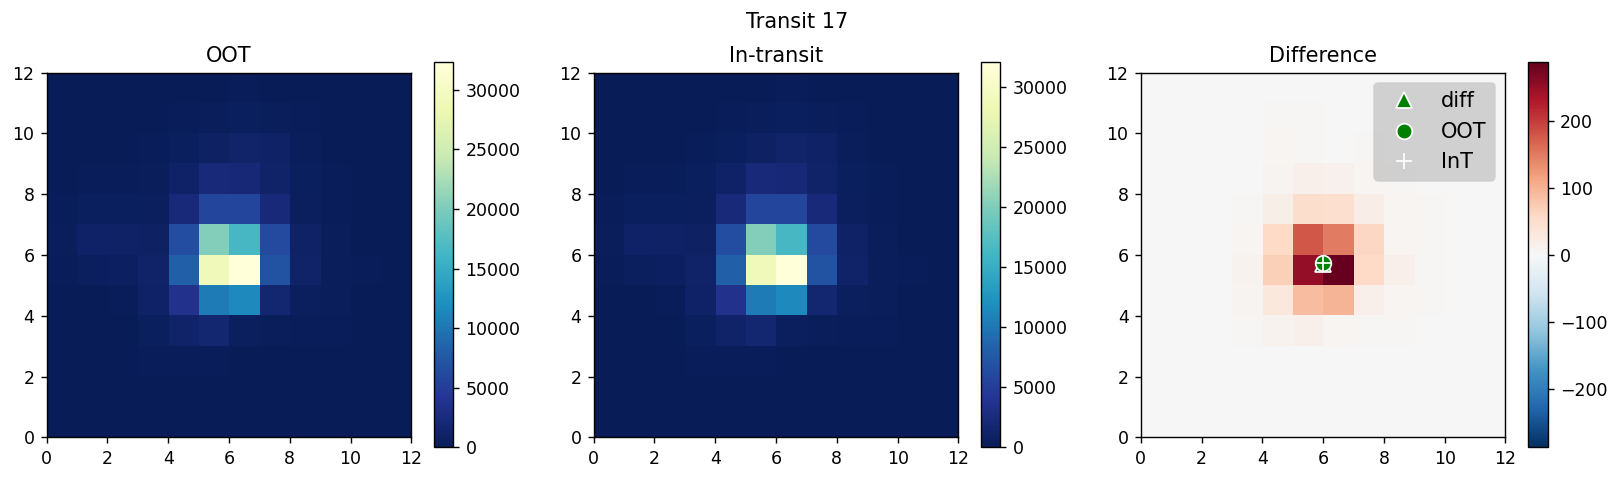

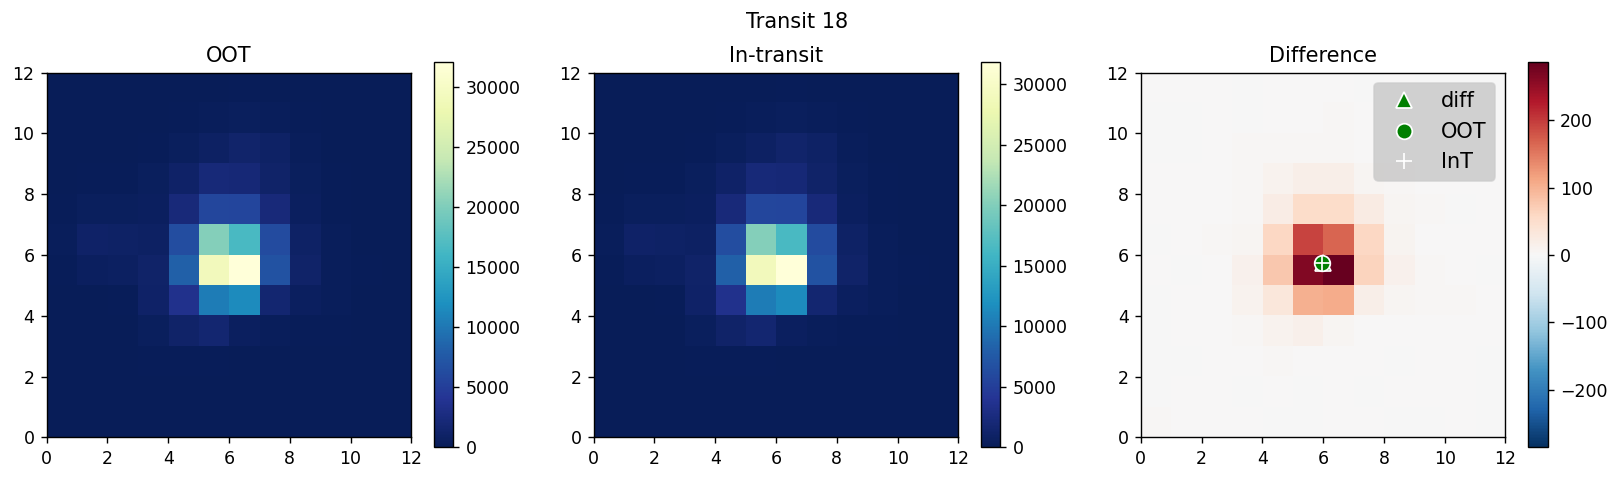

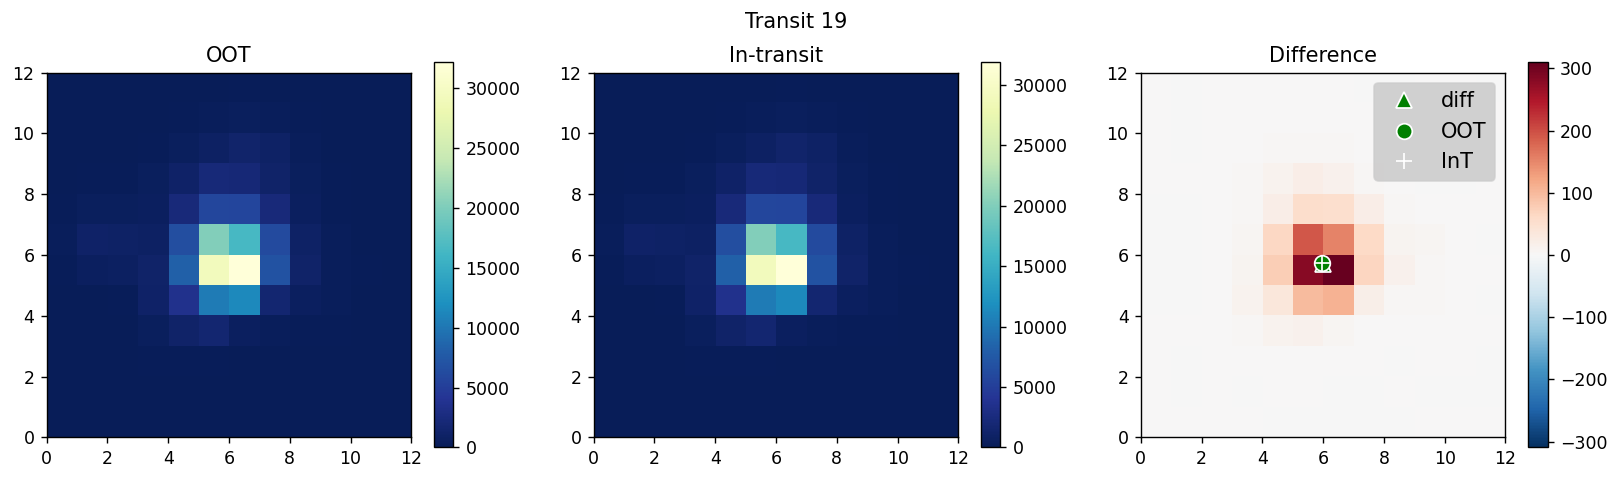

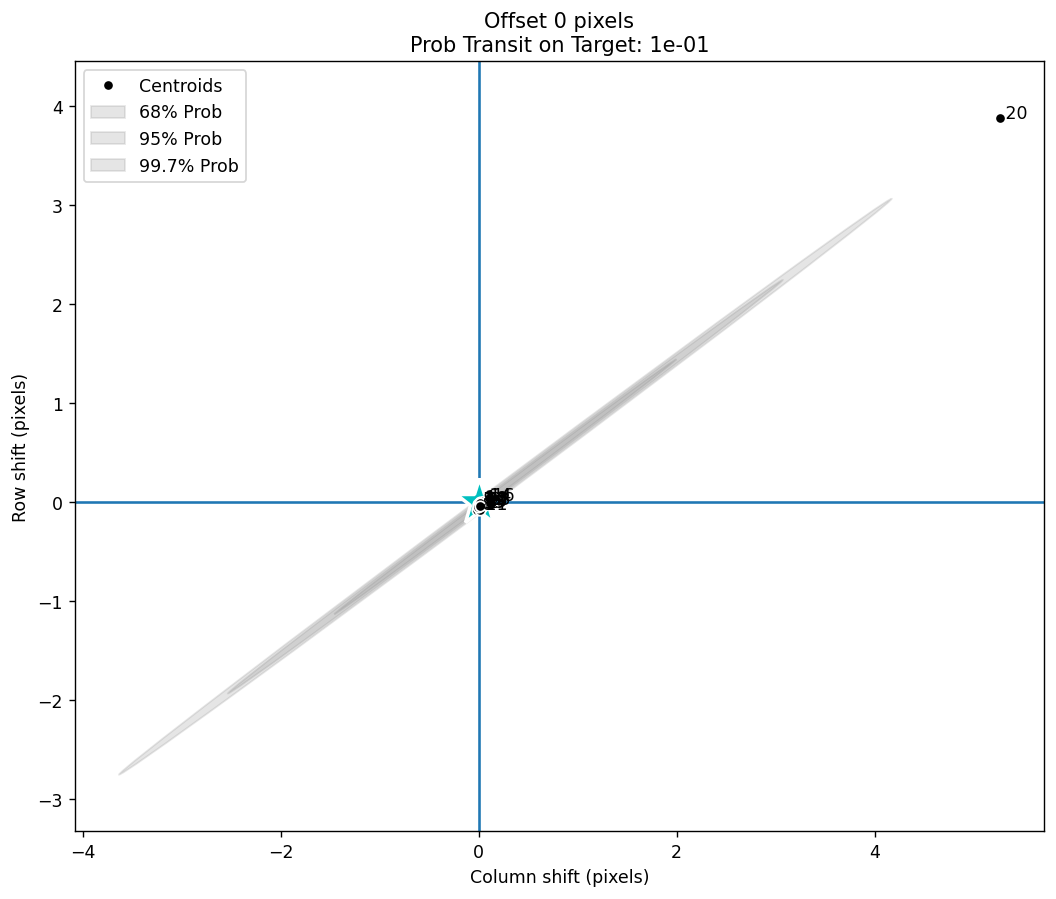

In [10]:
# Initialize and run the centroid vetter
cent = vet.Centroid()
cent.run(tce, tpf, plot=True) 


number of figs 20
number of centroids 20


{'offset': 0.035324348658500586, 'significance': array([0.13489322])}

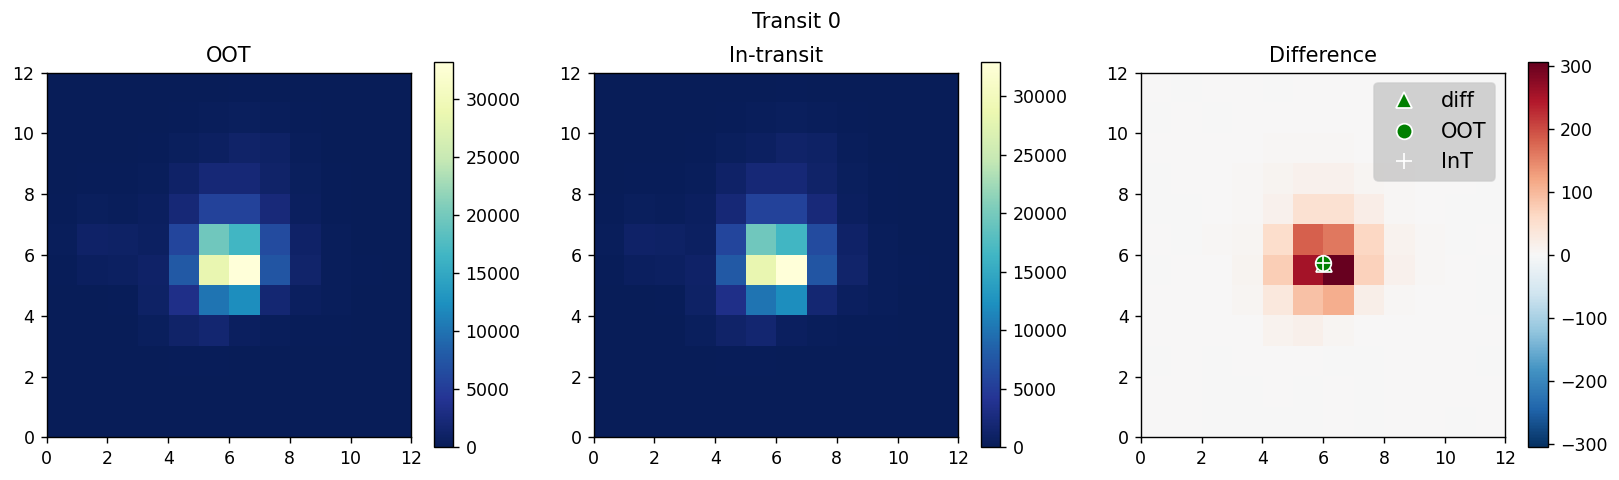

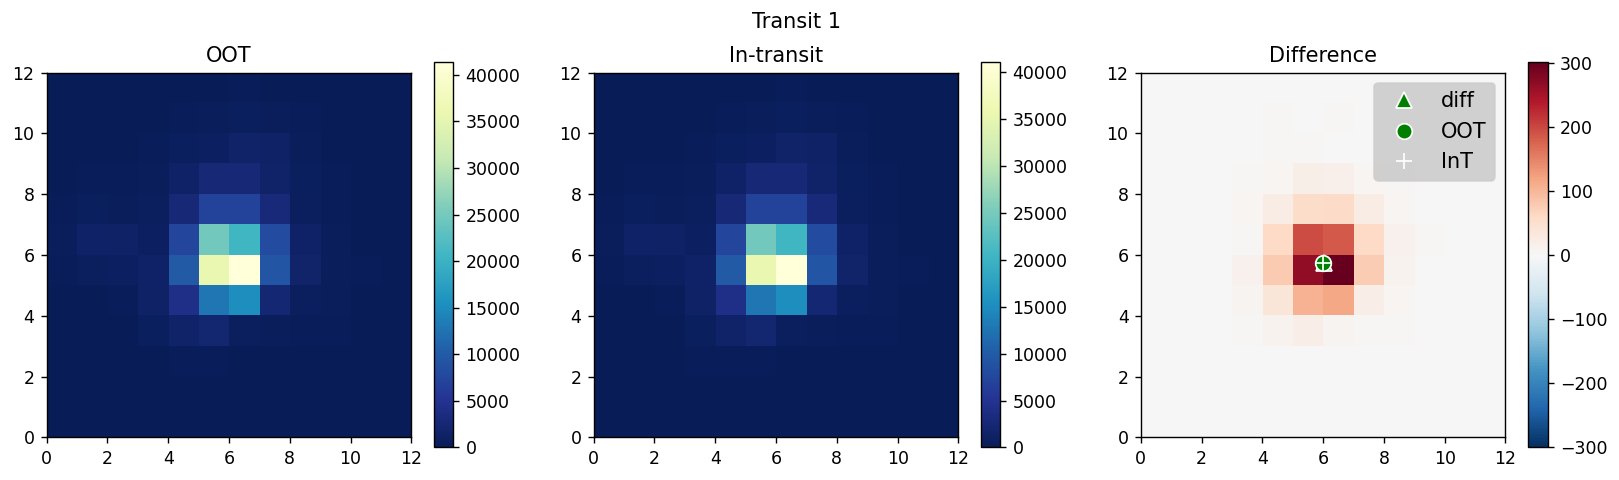

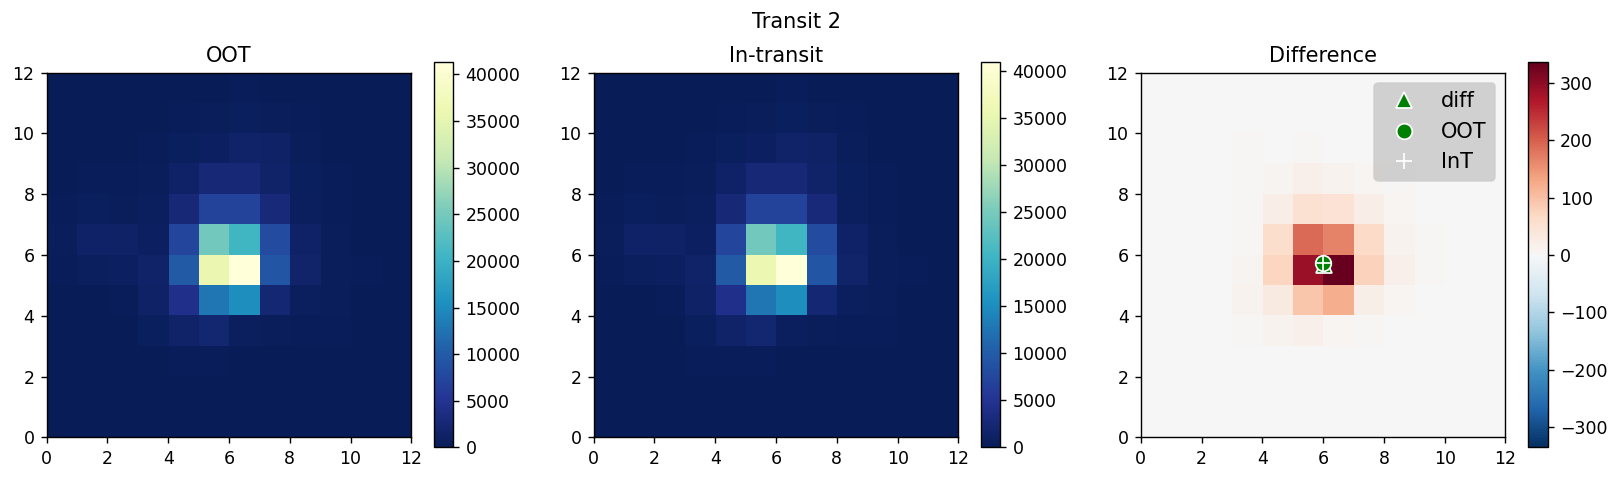

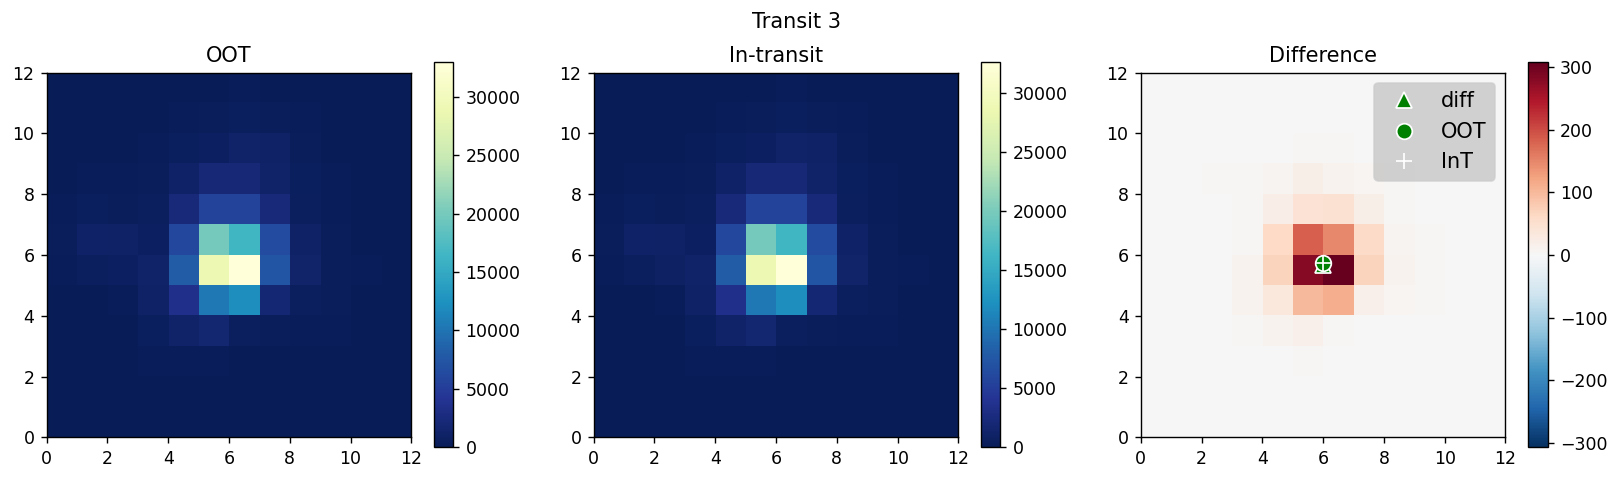

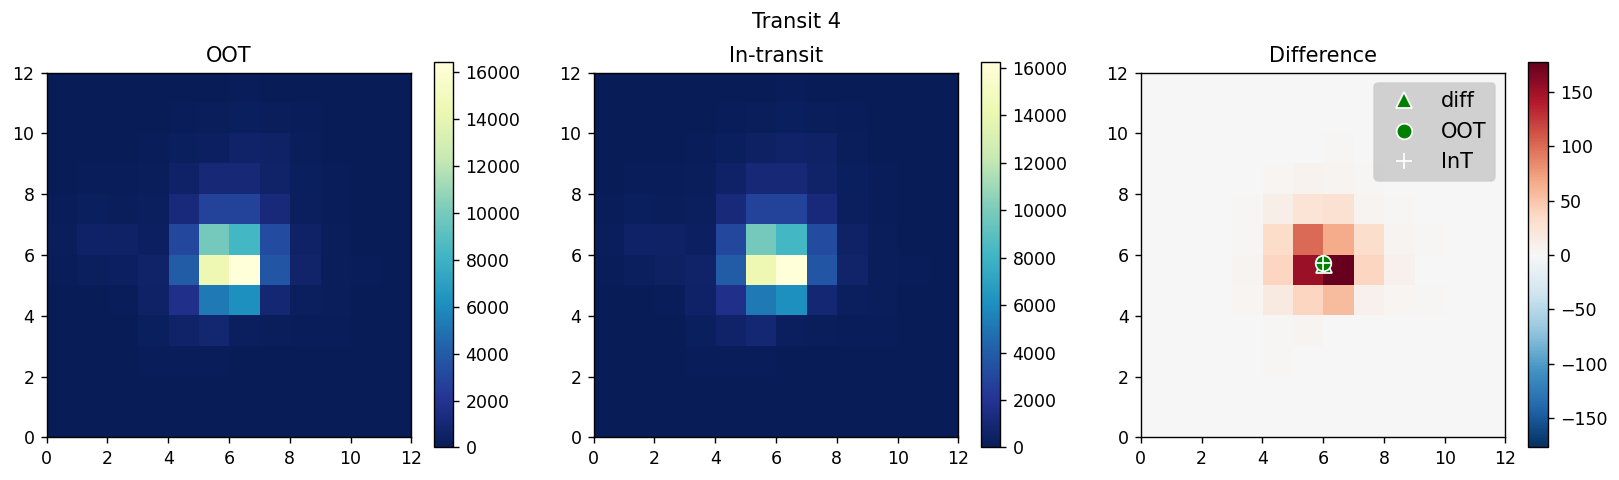

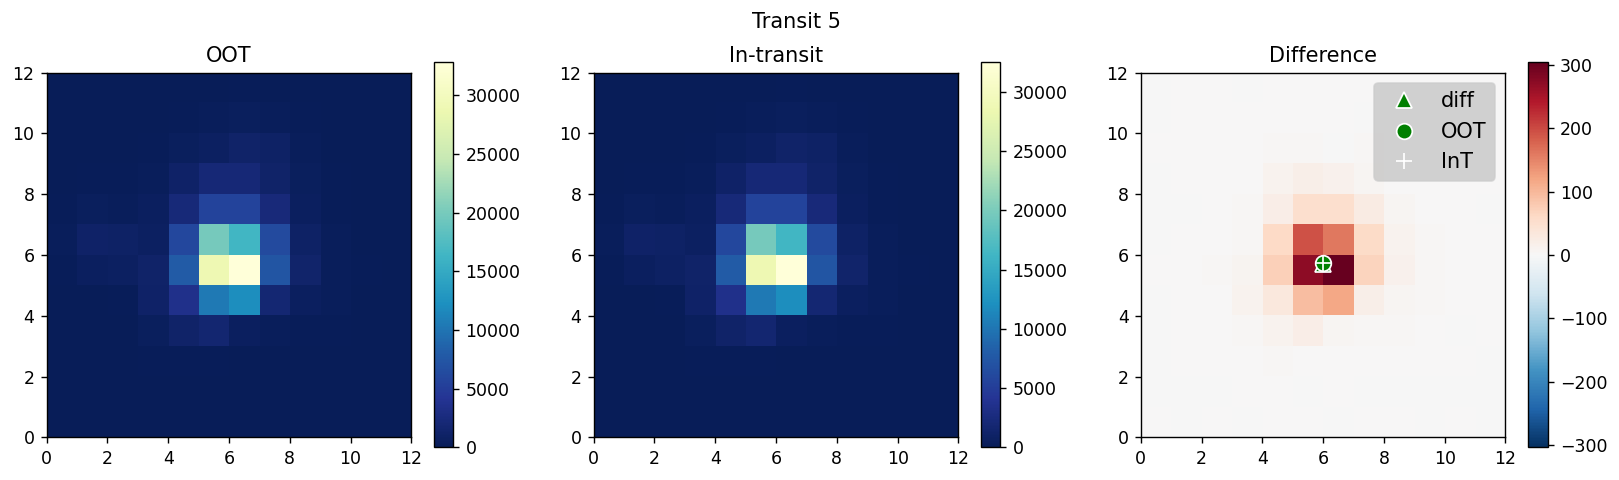

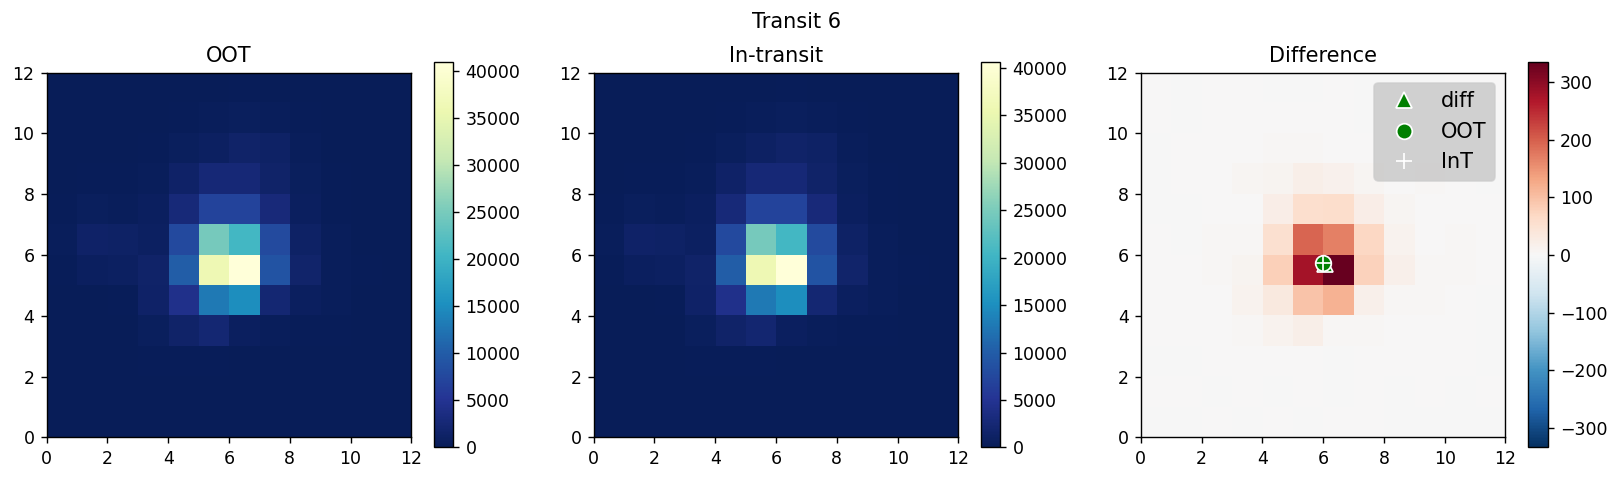

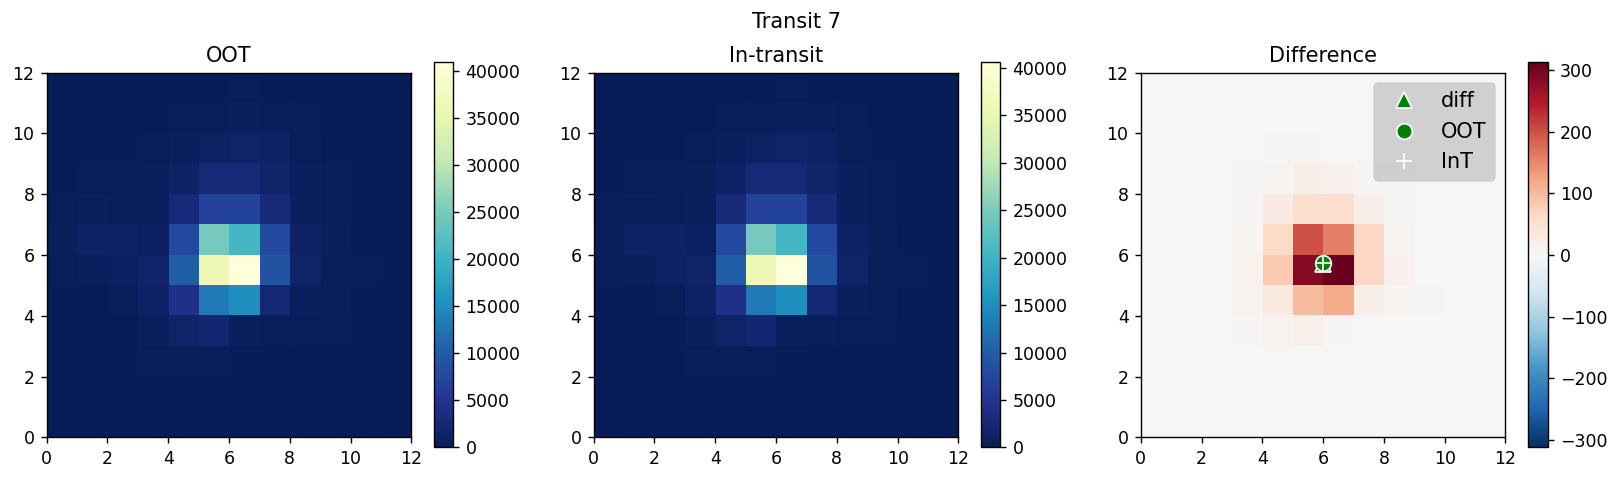

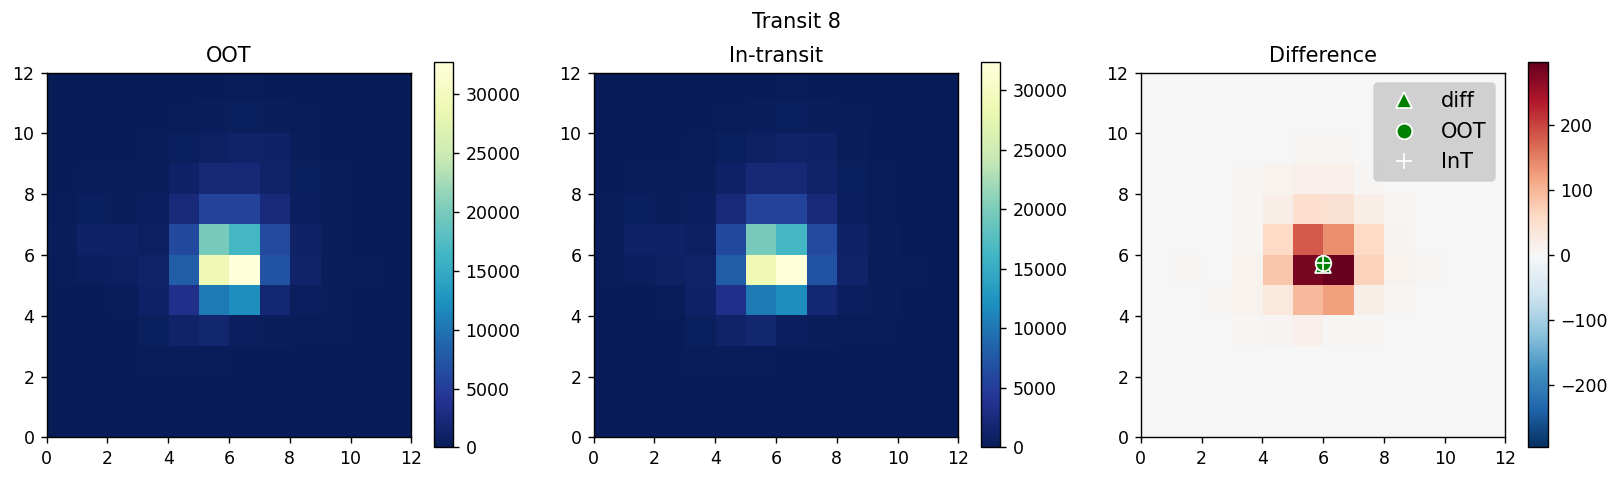

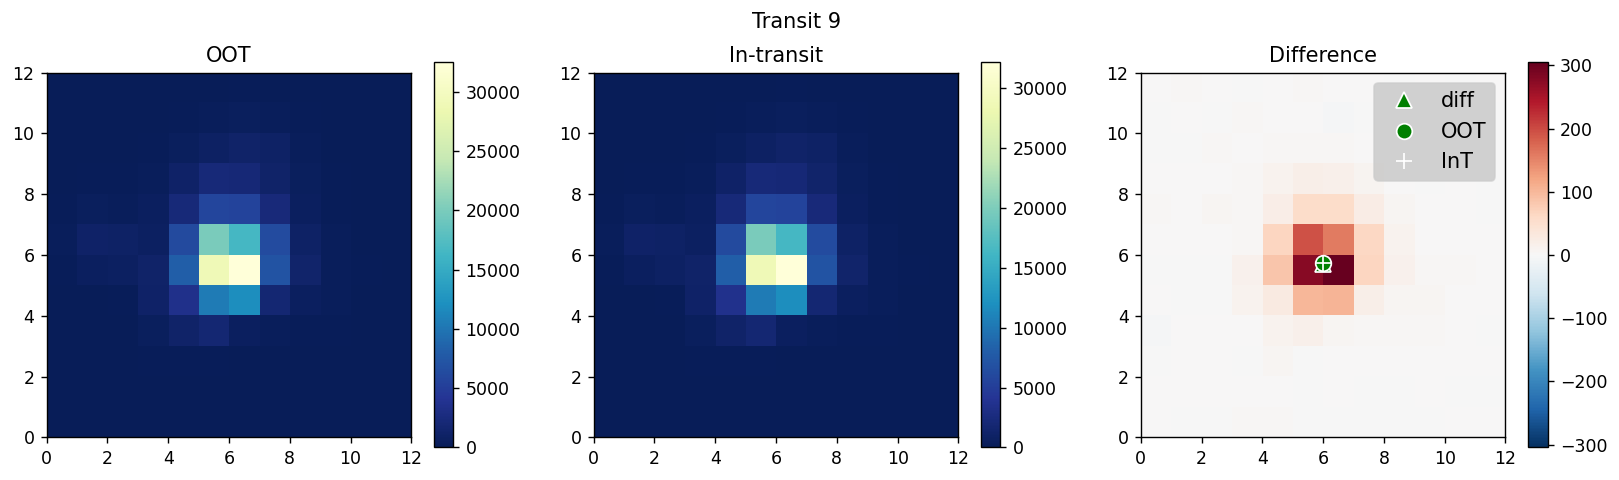

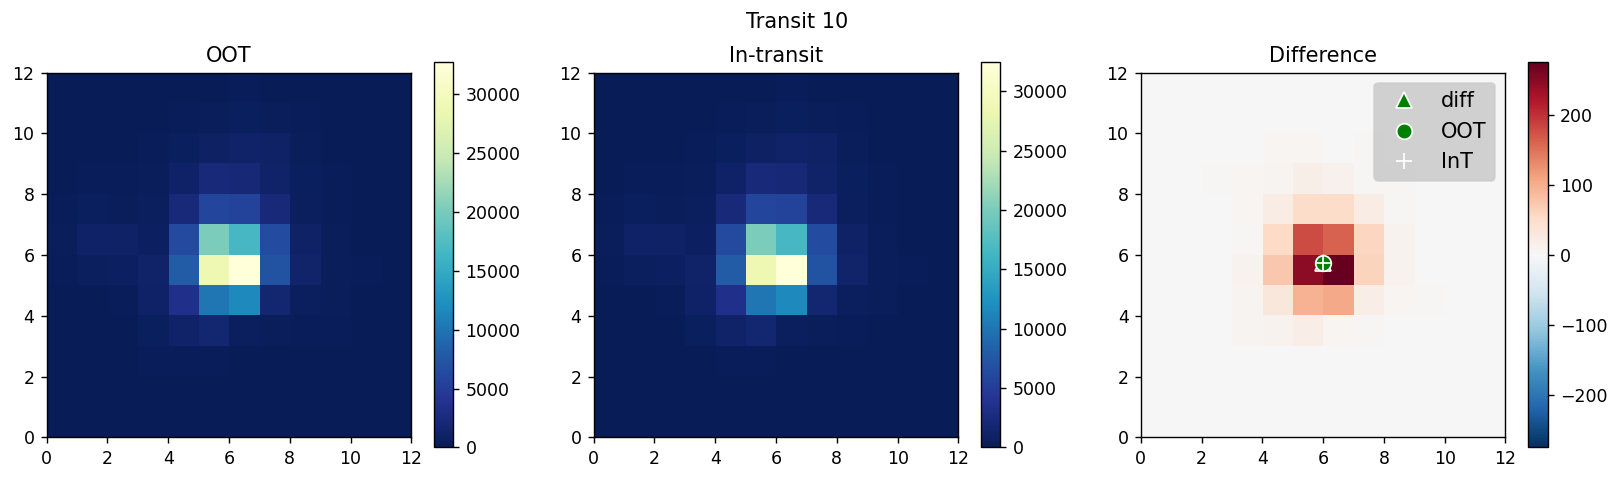

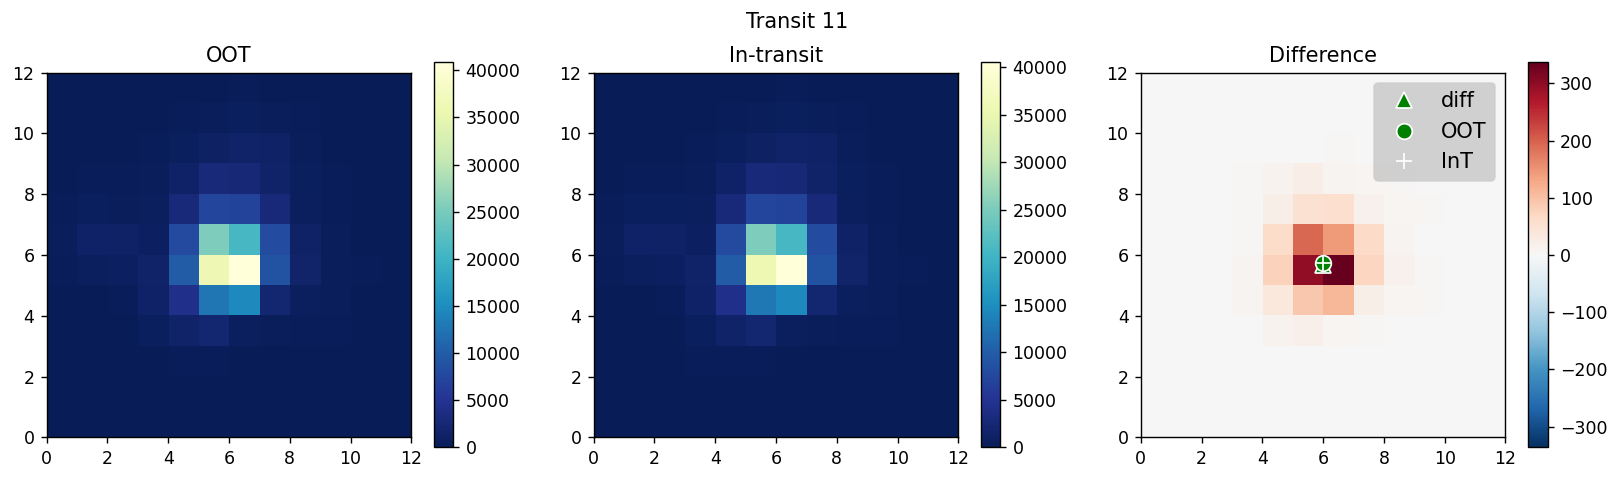

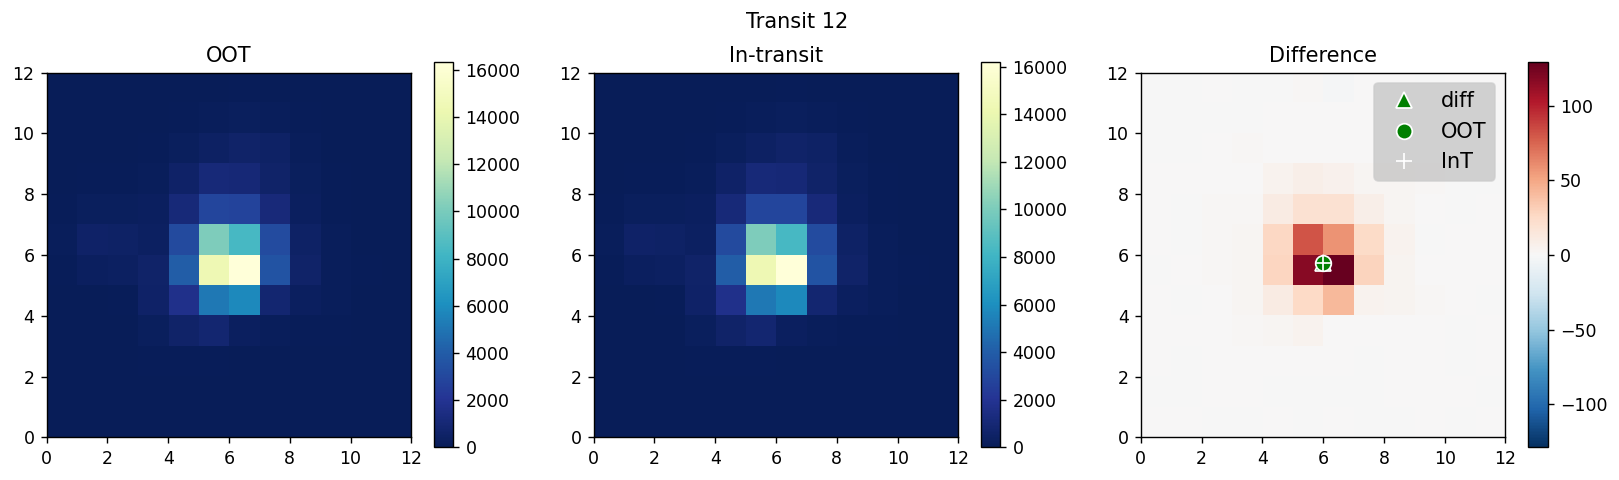

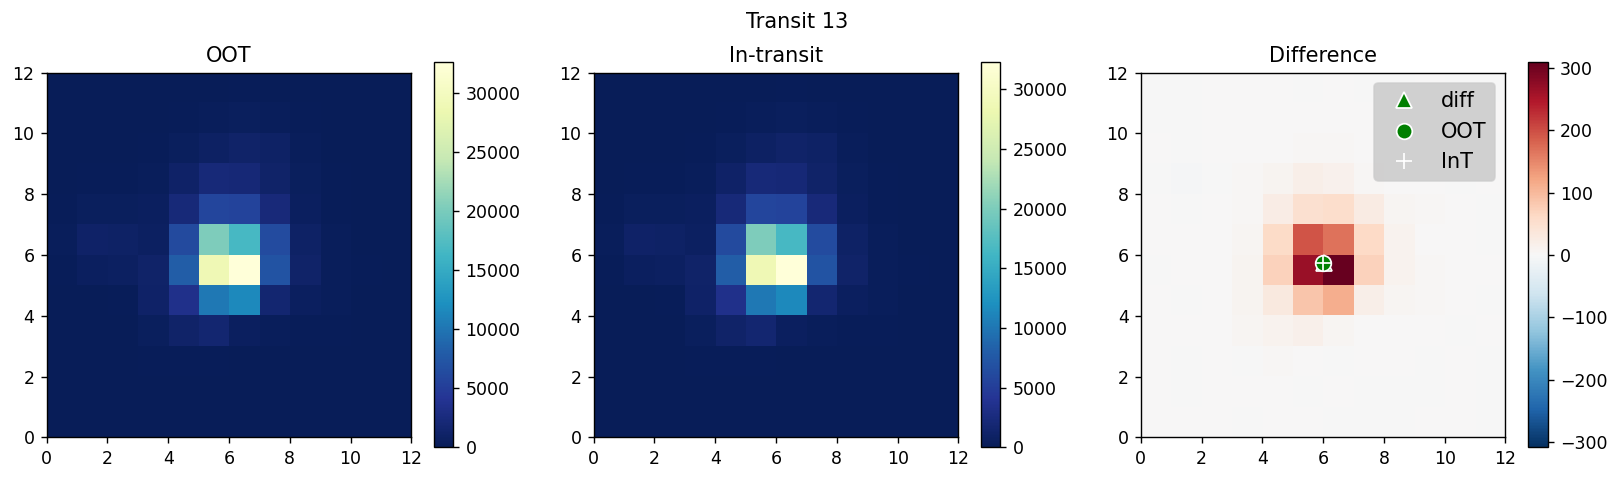

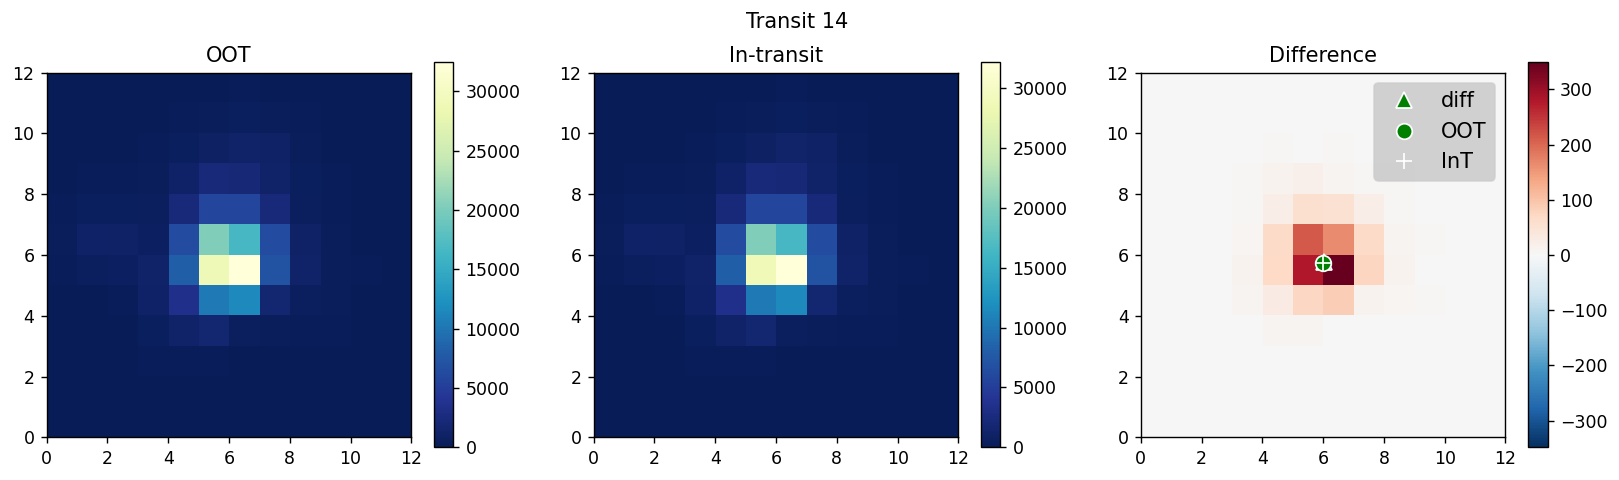

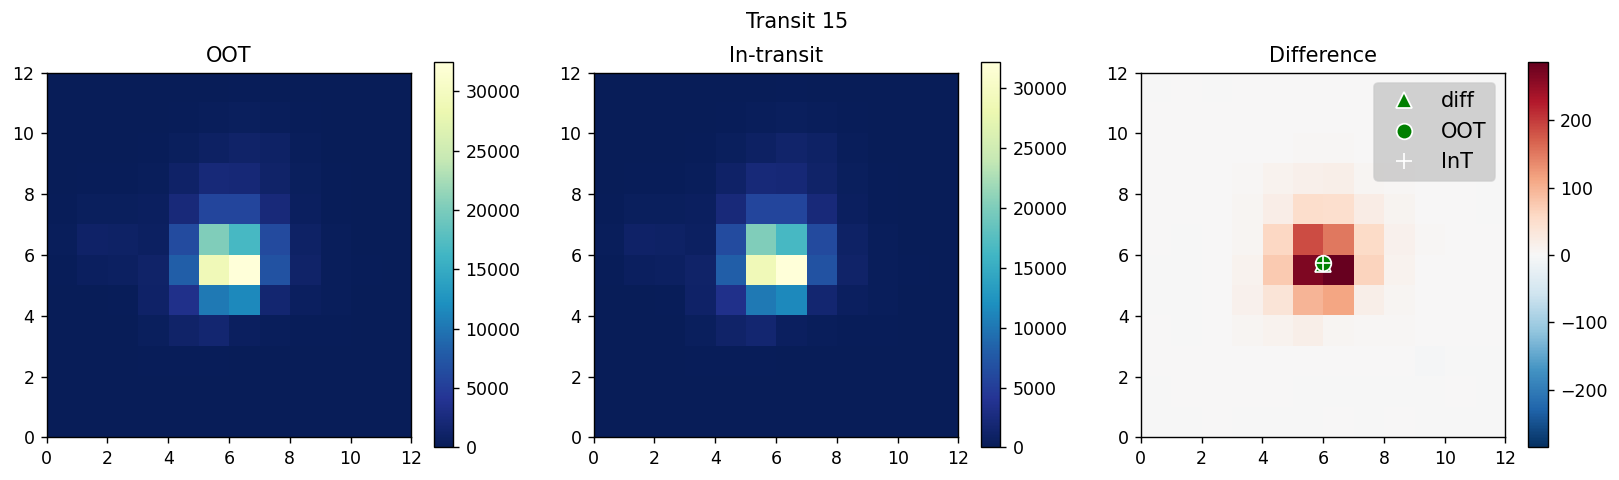

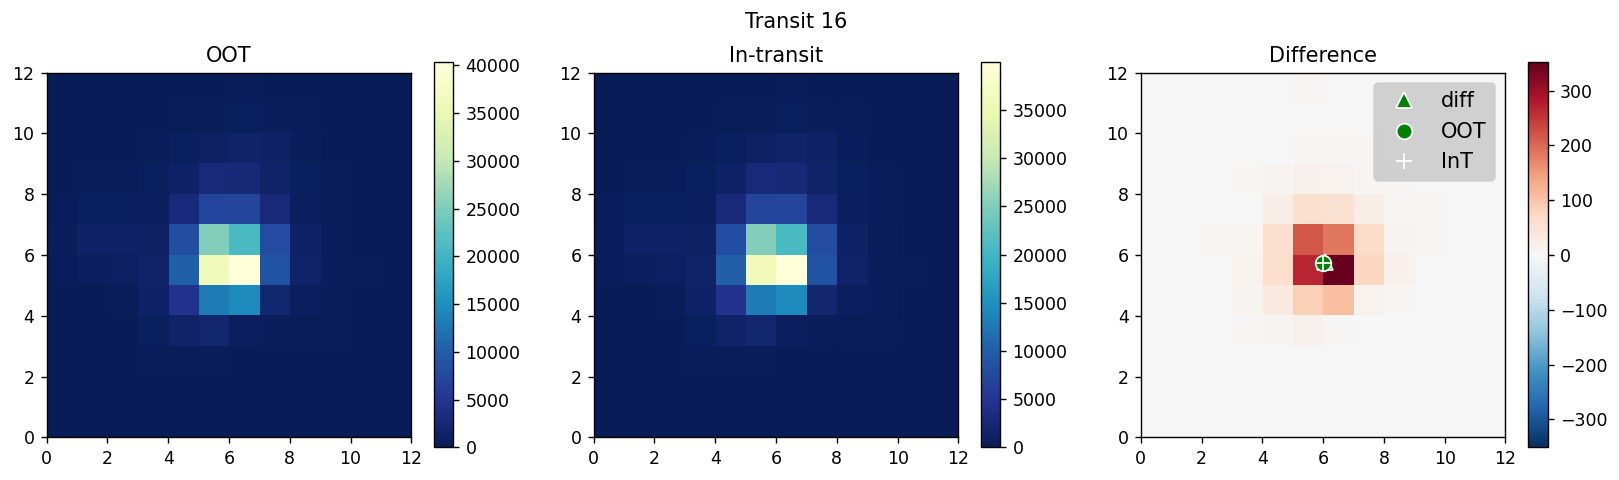

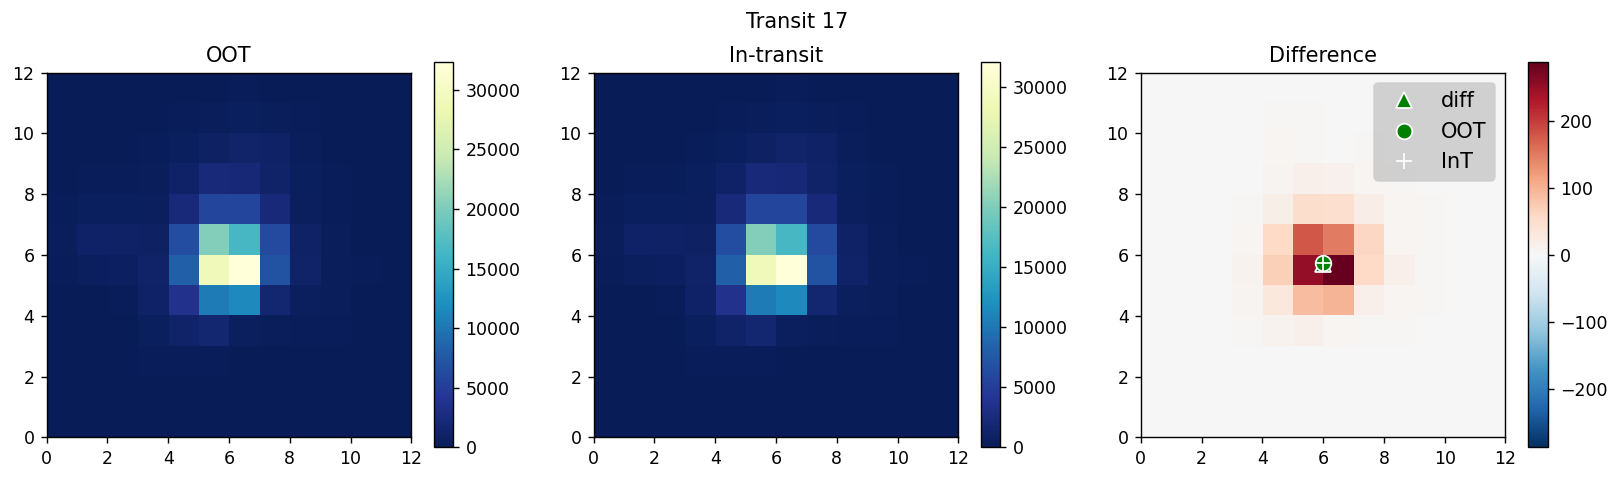

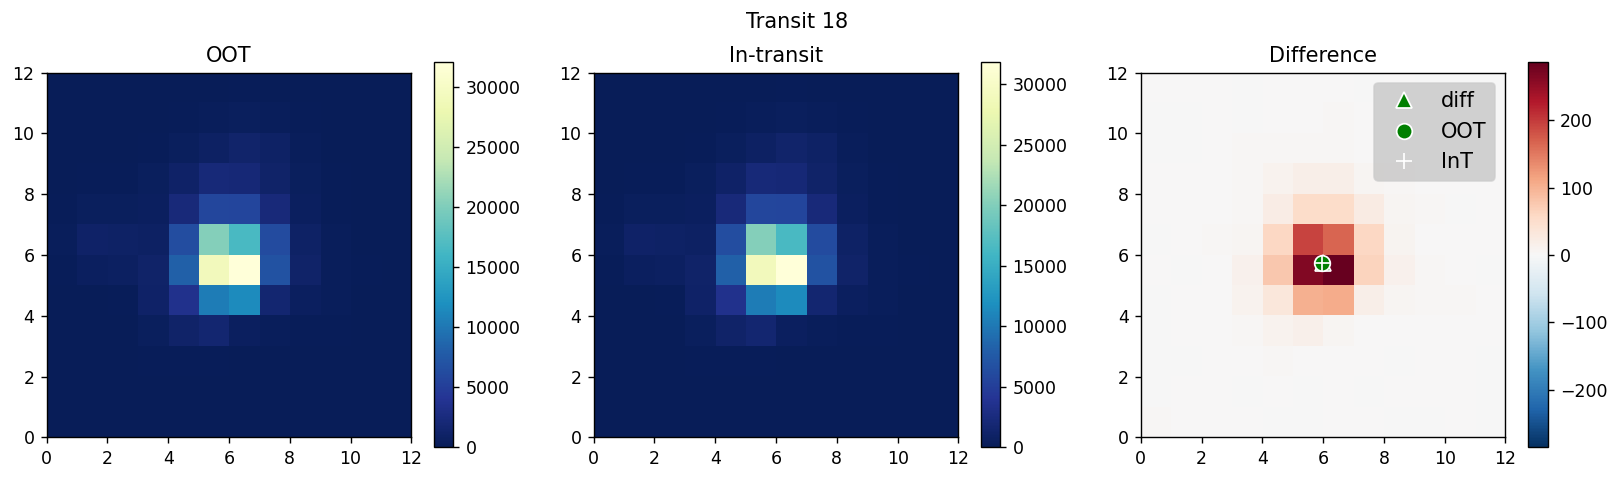

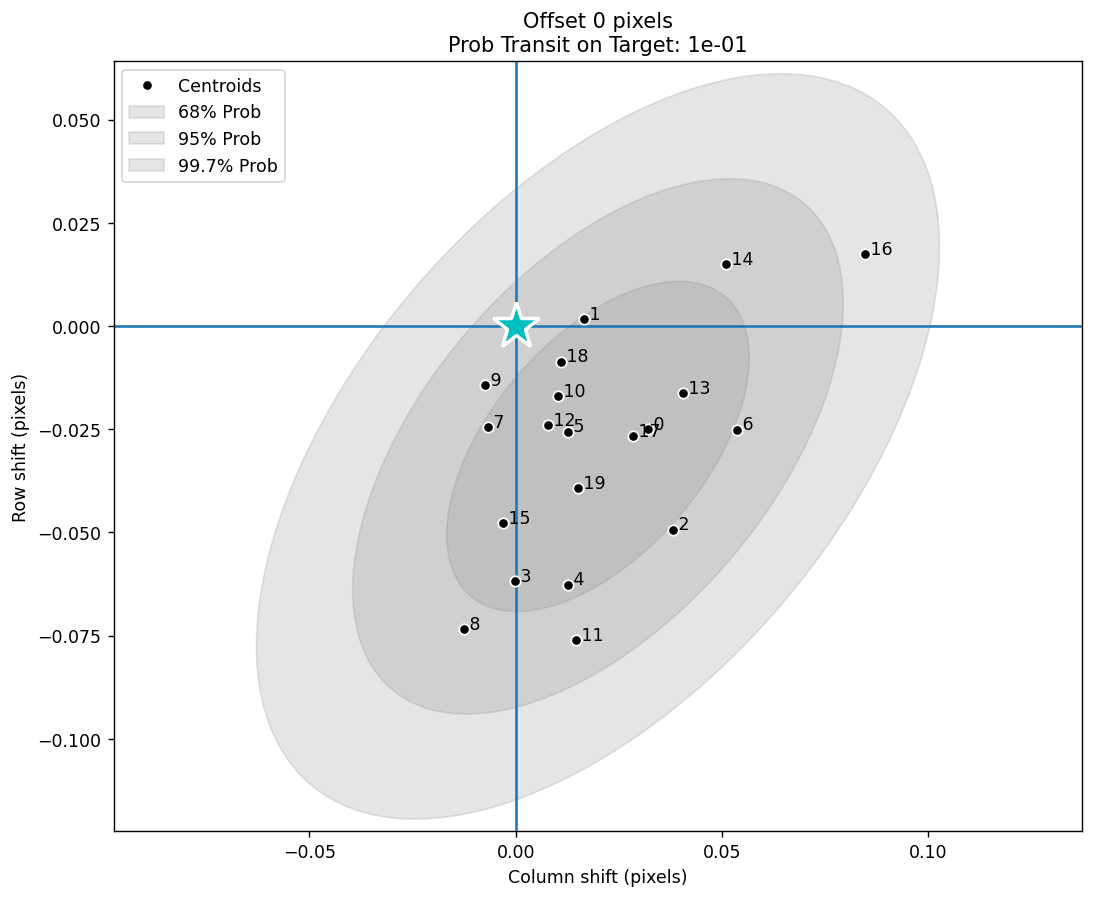

In [11]:
cent.run(tce, tpf, plot=True, unpermitted_transits=[20]) 


## Example of the centroid vetting by finding a small but possible offset

Here we will do the same thing on TOI 565.01

In [12]:
# Another way to get a tce is by using the get_mast_tce utility function 
candidate = "TOI 565.01"
new_tce = utils.get_mast_tce(candidate)[0]
new_tce

{'period': <Quantity 3.72716413 d>,
 'epoch': <Quantity 58519.370491 d>,
 'epoch_offset': <Quantity -2400000.5 d>,
 'depth': <Quantity 0.01747671>,
 'duration': <Quantity 0.16139208 d>,
 'target': 'TOI 565.01'}

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

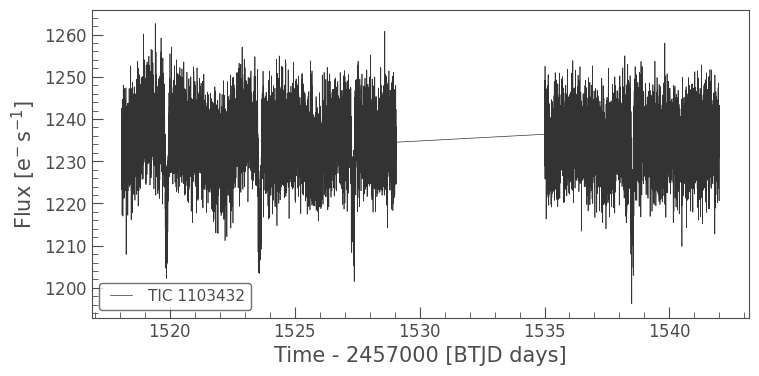

In [13]:
# We can also condense the steps to access a lightcurve further and use the plot method to see what it is  
lc = lk.search_lightcurve(candidate)[0].download()
lc.plot()

{'num_transits': 6}

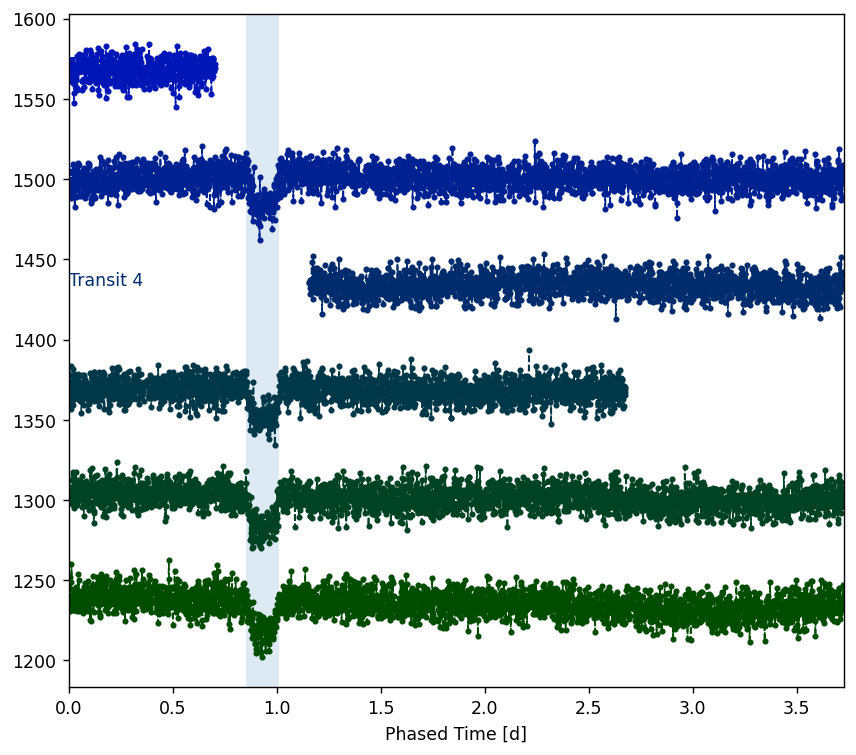

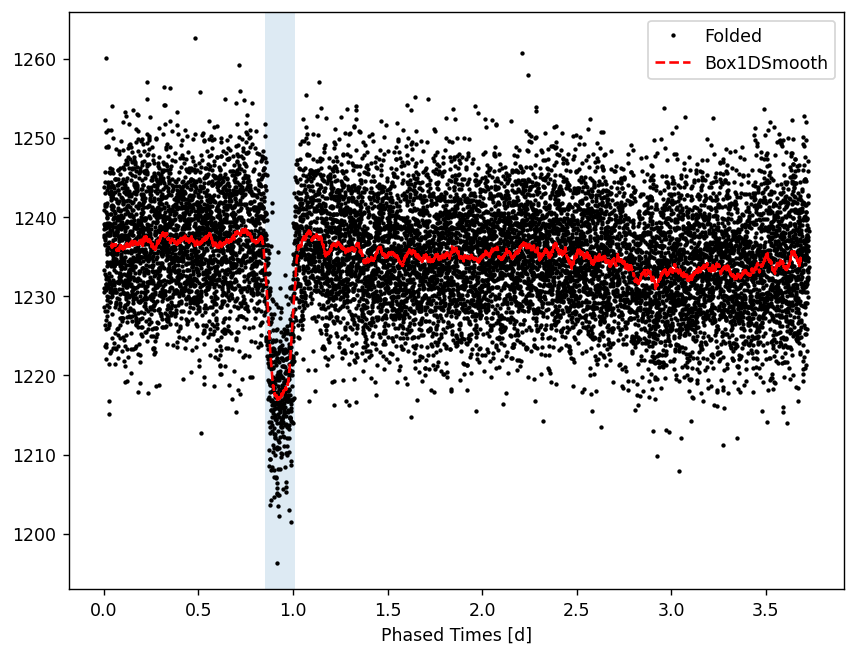

In [14]:
# Again using VizTransits but with different parameters
viz = vet.VizTransits(max_transits=8)
viz.run(new_tce, lc, plot=True)

number of figs 4
number of centroids 4


{'offset': 1.280240445042257, 'significance': array([9.57840576e-206])}

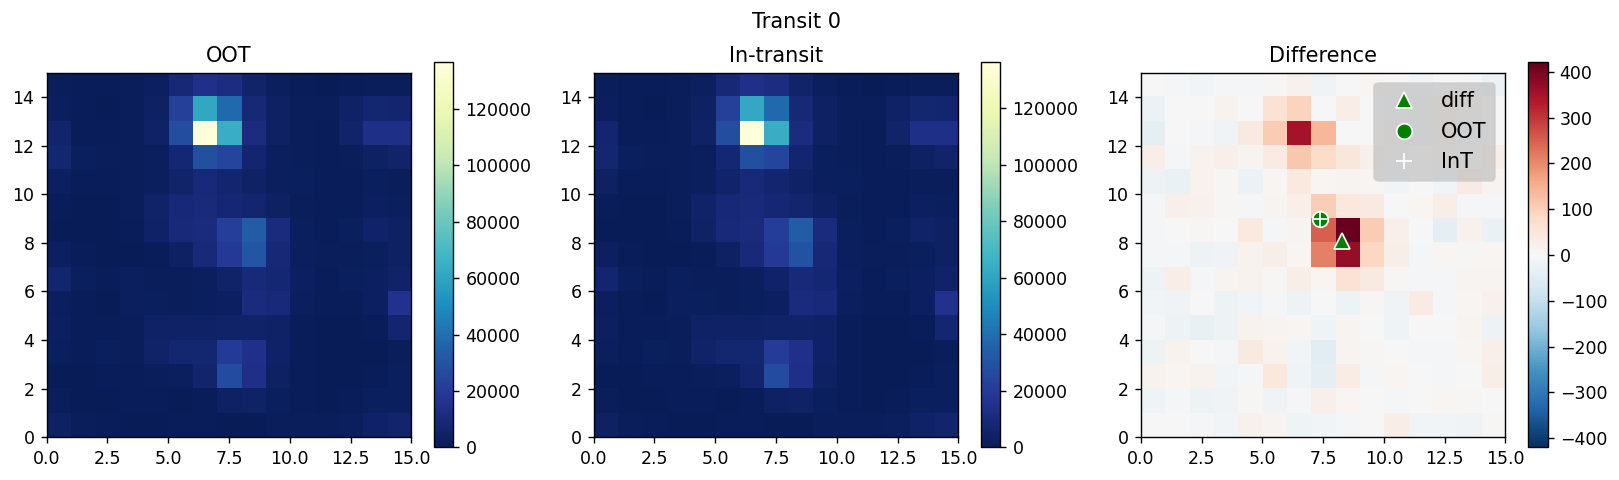

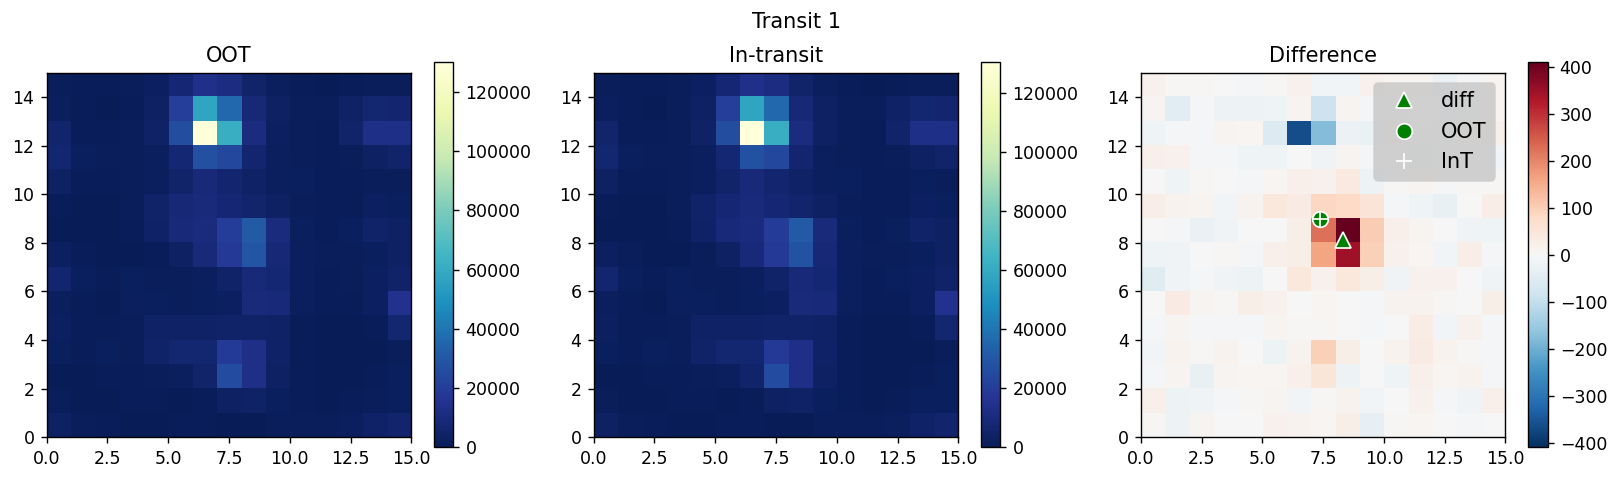

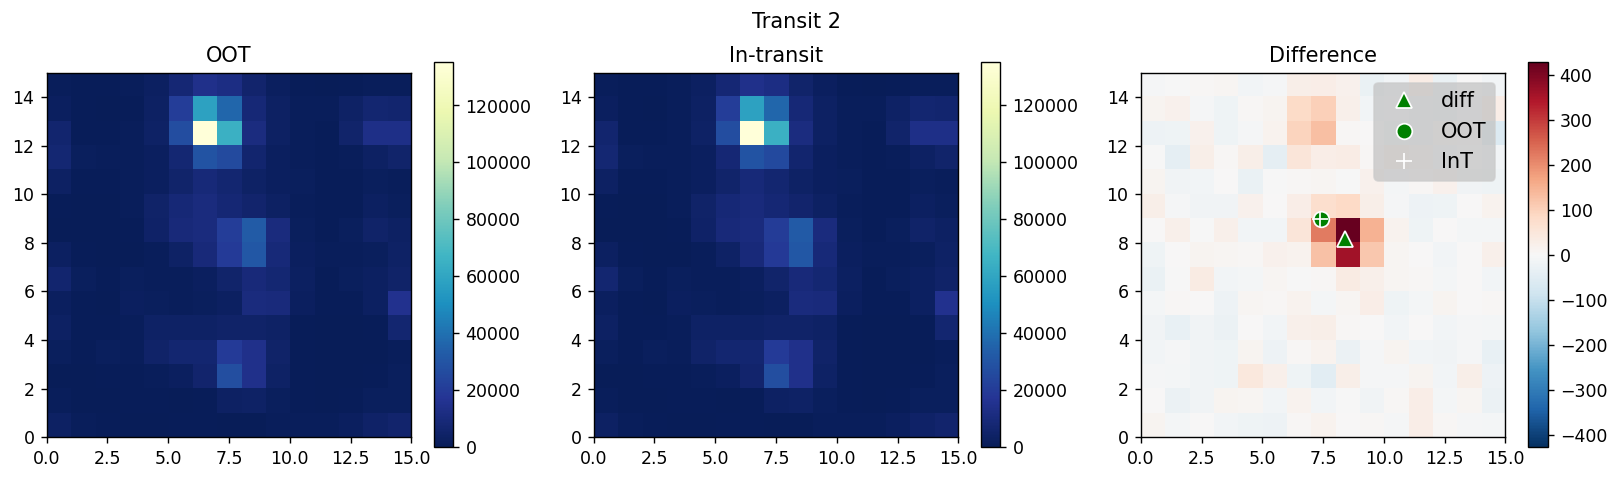

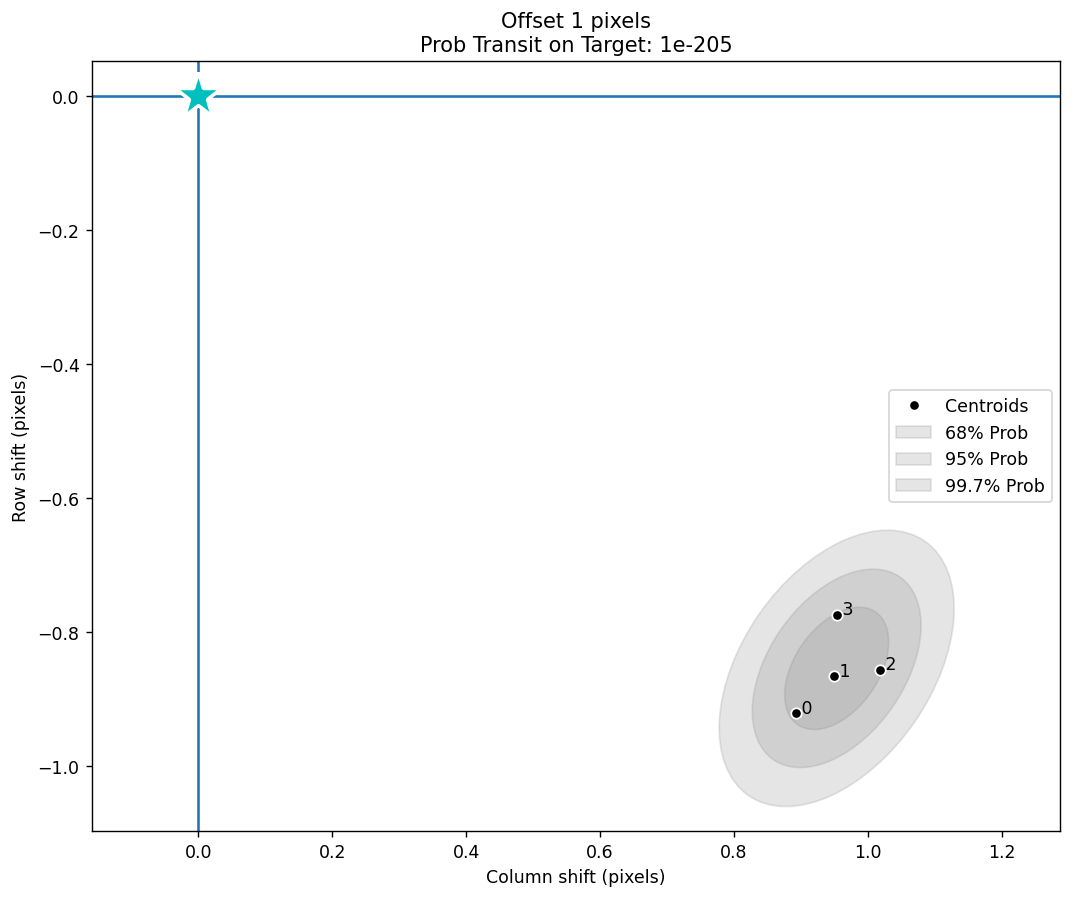

In [15]:
# Use the centroid vetter to examine difference images and measure centroids
new_tpf = lk.search_targetpixelfile(candidate)[0].download()
cent = vet.Centroid()
cent.run(new_tce, new_tpf, plot=True)